In [1]:
import vectorize
import pandas as pd
from tqdm import tqdm
import fasttext.util
import preprocess
import datetime

import spacy_stanza
from spacytextblob.spacytextblob import SpacyTextBlob
import re

nlp = spacy_stanza.load_pipeline("en", use_gpu=False)

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.preprocessing.sequence import pad_sequences
from keras.layers import MaxPool1D, GlobalAveragePooling1D, GlobalAveragePooling2D, Input, CategoryEncoding, Bidirectional, GRU, Dense, LSTM, Concatenate, Dropout, Lambda, Conv1D, Conv2D, Conv3D, BatchNormalization, MaxPooling1D, MaxPool2D, MaxPool3D, Reshape, Flatten, GlobalAveragePooling3D

#from gensim.models import FastText
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import matplotlib.pyplot as plt
#import os.path
from scipy import stats
from keras import losses

from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import swifter
import os

fasttext.util.download_model('en', if_exists='ignore')
d2vmodel = fasttext.load_model('cc.en.300.bin')

tqdm.pandas()

%config Completer.use_jedi = False

/home/kr/anaconda3/envs/nlp/lib/python3.8/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
2022-02-28 12:52:35 INFO: Loading these models for language: en (English):
| Processor    | Package   |
----------------------------
| tokenize     | combined  |
| pos          | combined  |
| lemma        | combined  |
| depparse     | combined  |
| sentiment    | sstplus   |
| constituency | wsj       |
| ner          | ontonotes |

2022-02-28 12:52:35 INFO: Use device: cpu
2022-02-28 12:52:35 INFO: Loading: tokenize
2022-02-28 12:52:35 INFO: Loading: pos
2022-02-28 12:52:36 INFO: Loading: lemma
2022-02-28 12:52:36 INFO: Loading: deppars

In [2]:
df = pd.read_excel('yulu_dataanalysis_bp.xlsx').fillna('').drop(['Unnamed: 0'], axis = 1)

In [3]:
for col in df.columns:
    df.rename(columns = {col:''.join(col.strip().lower().split(' '))}, inplace = True)
    df.rename(columns = {col:''.join(col.strip().lower().split('_'))}, inplace = True)

In [4]:
def func(x):
    if not x:
        return ['xxxxx xxxxx']
    else:
        return x
df['phrase_list'] = df['phrase_list'].apply(lambda x: [x_[1:-1] for x_ in x.strip('][').split(', ')])
df['phrase_list'] = df['phrase_list'].apply(lambda x: [x_ for x_ in x if len(x_.strip().split(' ')) == 2])
df['phrase_list'] = df['phrase_list'].apply(lambda x: func(x))

In [8]:
df.to_excel('yulu_dataanalysis_bp.xlsx')

In [6]:
df = df[['rev_content', 'phrase_list'] + list(df.columns[1:-1])]

In [16]:
for col in df.columns[2:]:
    df[col] = df[col].apply(lambda x: bool(x))

In [9]:
y = df[df.columns[2:]].to_numpy()

In [10]:
df['cp_array'] = df['phrase_list'].swifter.apply(lambda x: vectorize.vectorize(x, True, d2vmodel).array())
df['c_array'] = df['rev_content'].swifter.apply(lambda x: vectorize.vectorize(preprocess.preprocess(x).text.split(' '), True, d2vmodel).array())
df['g_array'] = df['rev_content'].swifter.apply(lambda x: np.array([[token.dep, token.ent_type, token.head.i, token.pos, token.tag] for token in preprocess.preprocess(x, True, nlp).nlp(preprocess.preprocess(x).text)]))

Pandas Apply:   0%|          | 0/420 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/420 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/420 [00:00<?, ?it/s]

In [10]:
del d2vmodel
del nlp

In [12]:
X_cp = df['cp_array'].to_list()
X_c = df['c_array'].to_list()
X_g = df['g_array'].to_list()
X_cp = pad_sequences(X_cp, dtype='float64', maxlen=100)
X_c = pad_sequences(X_c, dtype='float64', maxlen=200)
X_g = pad_sequences(X_g, dtype='int64', maxlen=200)
X_cp = np.expand_dims(X_cp, axis=1)
X_c = np.expand_dims(X_c, axis=1)
X_g = np.expand_dims(X_g, axis=3)
X_cp = np.swapaxes(X_cp, 1, 4)
X_c = np.swapaxes(X_c, 1, 3)
X_cp = np.swapaxes(X_cp, 1, 3)
X_c = np.swapaxes(X_c, 1, 2)
y = y*1

In [13]:
y_ = {}
for index, col in zip(range(y.shape[1]), df.columns[2:-2]):
    y_[col] = y.T[index]

In [14]:
for category in y_.keys():
    y_[category] = tf.keras.utils.to_categorical(y_[category], num_classes=2, dtype = 'int8')

In [15]:
X_cp.shape, X_c.shape, X_g.shape, y.shape

((420, 2, 100, 300, 1), (420, 200, 300, 1), (420, 200, 5, 1), (420, 9))

In [16]:
input_cp = Input(
    shape=X_cp.shape[1:], name='input_cp',
    #dtype=str(x_vec.dtype),
    batch_size = None,
    #ragged=True
)
#input = Flatten()(input)

input_c = Input(
    shape=X_c.shape[1:], name='input_c',
    #dtype=str(x_vec.dtype),
    batch_size = None,
    #ragged=True
)
#input = Flatten()(input)

input_g = Input(
    shape=X_g.shape[1:], name='input_g',
    #dtype=str(x_vec.dtype),
    batch_size = None,
    #ragged=True
)
#input = Flatten()(input)

In [17]:
input_cp, input_c, input_g

(<KerasTensor: shape=(None, 2, 100, 300, 1) dtype=float32 (created by layer 'input_cp')>,
 <KerasTensor: shape=(None, 200, 300, 1) dtype=float32 (created by layer 'input_c')>,
 <KerasTensor: shape=(None, 200, 5, 1) dtype=float32 (created by layer 'input_g')>)

In [18]:
layers_cp = []

###L0
layers_cp.append(Conv3D(filters=16, kernel_size=1, activation="relu")(input_cp))
layers_cp.append(MaxPool3D(pool_size=2)(layers_cp[-1]))
layers_cp.append(BatchNormalization()(layers_cp[-1]))

layers_cp.append(Reshape((50, 150, 16, 1))(layers_cp[-1]))

layers_cp.append(Conv3D(filters=16, kernel_size=2, activation="relu")(layers_cp[-1]))
layers_cp.append(MaxPool3D(pool_size=2)(layers_cp[-1]))
layers_cp.append(BatchNormalization()(layers_cp[-1]))

#layers_cp.append(Reshape((24, 74, 4, 1))(layers_cp[-1]))

layers_cp.append(Conv3D(filters=256, kernel_size=2, activation="relu")(layers_cp[-1]))
layers_cp.append(MaxPool3D(pool_size=2)(layers_cp[-1]))
layers_cp.append(BatchNormalization()(layers_cp[-1]))#

layers_cp.append(GlobalAveragePooling3D()(layers_cp[-1]))

layers_cp.append(Dense(512, activation="relu")(layers_cp[-1]))
layers_cp.append(Dropout(0.3)(layers_cp[-1]))
layers_cp.append(Dense(512, activation="relu")(layers_cp[-1]))
layers_cp.append(Dropout(0.3)(layers_cp[-1]))
layers_cp.append(Reshape((layers_cp[-1].shape[1], 1))(layers_cp[-1]))
layers_cp
#layers.append(Dense(1, activation="sigmoid")(layers[-1]))

[<KerasTensor: shape=(None, 2, 100, 300, 16) dtype=float32 (created by layer 'conv3d')>,
 <KerasTensor: shape=(None, 1, 50, 150, 16) dtype=float32 (created by layer 'max_pooling3d')>,
 <KerasTensor: shape=(None, 1, 50, 150, 16) dtype=float32 (created by layer 'batch_normalization')>,
 <KerasTensor: shape=(None, 50, 150, 16, 1) dtype=float32 (created by layer 'reshape')>,
 <KerasTensor: shape=(None, 49, 149, 15, 16) dtype=float32 (created by layer 'conv3d_1')>,
 <KerasTensor: shape=(None, 24, 74, 7, 16) dtype=float32 (created by layer 'max_pooling3d_1')>,
 <KerasTensor: shape=(None, 24, 74, 7, 16) dtype=float32 (created by layer 'batch_normalization_1')>,
 <KerasTensor: shape=(None, 23, 73, 6, 256) dtype=float32 (created by layer 'conv3d_2')>,
 <KerasTensor: shape=(None, 11, 36, 3, 256) dtype=float32 (created by layer 'max_pooling3d_2')>,
 <KerasTensor: shape=(None, 11, 36, 3, 256) dtype=float32 (created by layer 'batch_normalization_2')>,
 <KerasTensor: shape=(None, 256) dtype=float32 

In [19]:
layers_c = []

###L0
layers_c.append(Conv2D(filters=16, kernel_size=1, activation="relu")(input_c))
layers_c.append(MaxPool2D(pool_size=2)(layers_c[-1]))
layers_c.append(BatchNormalization()(layers_c[-1]))

layers_c.append(Reshape((layers_c[-1].shape[1], layers_c[-1].shape[2]*layers_c[-1].shape[3], 1))(layers_c[-1]))

layers_c.append(Conv2D(filters=16, kernel_size=2, activation="relu")(layers_c[-1]))
layers_c.append(MaxPool2D(pool_size=2)(layers_c[-1]))
layers_c.append(BatchNormalization()(layers_c[-1]))

#layers_c.append(Reshape((24, 74, 4, 1))(layers_cp[-1]))

layers_c.append(Conv2D(filters=256, kernel_size=2, activation="relu")(layers_c[-1]))
layers_c.append(MaxPool2D(pool_size=2)(layers_c[-1]))
layers_c.append(BatchNormalization()(layers_c[-1]))#

layers_c.append(GlobalAveragePooling2D()(layers_c[-1]))

layers_c.append(Dense(512, activation="relu")(layers_c[-1]))
layers_c.append(Dropout(0.3)(layers_c[-1]))
layers_c.append(Dense(512, activation="relu")(layers_c[-1]))
layers_c.append(Dropout(0.3)(layers_c[-1]))
layers_c.append(Reshape((layers_c[-1].shape[1], 1))(layers_c[-1]))

layers_c

[<KerasTensor: shape=(None, 200, 300, 16) dtype=float32 (created by layer 'conv2d')>,
 <KerasTensor: shape=(None, 100, 150, 16) dtype=float32 (created by layer 'max_pooling2d')>,
 <KerasTensor: shape=(None, 100, 150, 16) dtype=float32 (created by layer 'batch_normalization_3')>,
 <KerasTensor: shape=(None, 100, 2400, 1) dtype=float32 (created by layer 'reshape_2')>,
 <KerasTensor: shape=(None, 99, 2399, 16) dtype=float32 (created by layer 'conv2d_1')>,
 <KerasTensor: shape=(None, 49, 1199, 16) dtype=float32 (created by layer 'max_pooling2d_1')>,
 <KerasTensor: shape=(None, 49, 1199, 16) dtype=float32 (created by layer 'batch_normalization_4')>,
 <KerasTensor: shape=(None, 48, 1198, 256) dtype=float32 (created by layer 'conv2d_2')>,
 <KerasTensor: shape=(None, 24, 599, 256) dtype=float32 (created by layer 'max_pooling2d_2')>,
 <KerasTensor: shape=(None, 24, 599, 256) dtype=float32 (created by layer 'batch_normalization_5')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by lay

In [20]:
layers_g = []

###L0
layers_g.append(Conv2D(filters=16, kernel_size=1, activation="relu")(input_g))
layers_g.append(BatchNormalization()(layers_g[-1]))

layers_g.append(Reshape((layers_g[-1].shape[1], layers_g[-1].shape[2]*layers_g[-1].shape[3], 1))(layers_g[-1]))

layers_g.append(Conv2D(filters=16, kernel_size=1, activation="relu")(layers_g[-1]))
layers_g.append(BatchNormalization()(layers_g[-1]))

#layers_g.append(Reshape((24, 74, 4, 1))(layers_g[-1]))

layers_g.append(Conv2D(filters=256, kernel_size=1, activation="relu")(layers_g[-1]))
layers_g.append(BatchNormalization()(layers_g[-1]))#

layers_g.append(GlobalAveragePooling2D()(layers_g[-1]))

layers_g.append(Dense(512, activation="relu")(layers_g[-1]))
layers_g.append(Dropout(0.3)(layers_g[-1]))
layers_g.append(Dense(512, activation="relu")(layers_g[-1]))
layers_g.append(Dropout(0.3)(layers_g[-1]))
layers_g.append(Reshape((layers_g[-1].shape[1], 1))(layers_g[-1]))

layers_g

[<KerasTensor: shape=(None, 200, 5, 16) dtype=float32 (created by layer 'conv2d_3')>,
 <KerasTensor: shape=(None, 200, 5, 16) dtype=float32 (created by layer 'batch_normalization_6')>,
 <KerasTensor: shape=(None, 200, 80, 1) dtype=float32 (created by layer 'reshape_4')>,
 <KerasTensor: shape=(None, 200, 80, 16) dtype=float32 (created by layer 'conv2d_4')>,
 <KerasTensor: shape=(None, 200, 80, 16) dtype=float32 (created by layer 'batch_normalization_7')>,
 <KerasTensor: shape=(None, 200, 80, 256) dtype=float32 (created by layer 'conv2d_5')>,
 <KerasTensor: shape=(None, 200, 80, 256) dtype=float32 (created by layer 'batch_normalization_8')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'global_average_pooling2d_1')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_4')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dropout_4')>,
 <KerasTensor: shape=(None, 512) dtype=float32 (created by layer 'dense_5')>,
 <KerasTensor: shap

In [21]:
layers_con = []
layers_con.append(Concatenate(axis = 2)([layers_cp[-1], layers_c[-1], layers_g[-1]]))


###L0
layers_con.append(Conv1D(filters=16, kernel_size=1, activation="relu")(layers_con[-1]))
layers_con.append(MaxPool1D(pool_size=2)(layers_con[-1]))
layers_con.append(BatchNormalization()(layers_con[-1]))

layers_con.append(Reshape((layers_con[-1].shape[1]*layers_con[-1].shape[2], 1))(layers_con[-1]))

layers_con.append(Conv1D(filters=16, kernel_size=1, activation="relu")(layers_con[-1]))
layers_con.append(BatchNormalization()(layers_con[-1]))

#layers_con.append(Reshape((24, 74, 4, 1))(layers_con[-1]))

layers_con.append(Conv1D(filters=256, kernel_size=1, activation="relu")(layers_con[-1]))
layers_con.append(BatchNormalization()(layers_con[-1]))#

layers_con.append(GlobalAveragePooling1D()(layers_con[-1]))

layers_con.append(Dense(1000, activation="relu")(layers_con[-1]))
layers_con.append(Dropout(0.3)(layers_con[-1]))
layers_con.append(Dense(300, activation="relu")(layers_con[-1]))
layers_con.append(Dropout(0.3)(layers_con[-1]))
#layers_con.append(Reshape((layers_con[-1].shape[1], 1))(layers_con[-1]))

layers_con

[<KerasTensor: shape=(None, 512, 3) dtype=float32 (created by layer 'concatenate')>,
 <KerasTensor: shape=(None, 512, 16) dtype=float32 (created by layer 'conv1d')>,
 <KerasTensor: shape=(None, 256, 16) dtype=float32 (created by layer 'max_pooling1d')>,
 <KerasTensor: shape=(None, 256, 16) dtype=float32 (created by layer 'batch_normalization_9')>,
 <KerasTensor: shape=(None, 4096, 1) dtype=float32 (created by layer 'reshape_6')>,
 <KerasTensor: shape=(None, 4096, 16) dtype=float32 (created by layer 'conv1d_1')>,
 <KerasTensor: shape=(None, 4096, 16) dtype=float32 (created by layer 'batch_normalization_10')>,
 <KerasTensor: shape=(None, 4096, 256) dtype=float32 (created by layer 'conv1d_2')>,
 <KerasTensor: shape=(None, 4096, 256) dtype=float32 (created by layer 'batch_normalization_11')>,
 <KerasTensor: shape=(None, 256) dtype=float32 (created by layer 'global_average_pooling1d')>,
 <KerasTensor: shape=(None, 1000) dtype=float32 (created by layer 'dense_6')>,
 <KerasTensor: shape=(None

In [22]:
class_wise = {}
for key in y_.keys(): 
    class_wise[key] = [
        Dense(
            1000,
            activation='relu',
            use_bias=True,
            bias_initializer='zeros',
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None,
    )(layers_con[-1])]
    class_wise[key][-1] = Dropout(0.5)(class_wise[key][-1])
    class_wise[key].append(
        Dense(
            100,
            activation='relu',
            use_bias=True,
            bias_initializer='zeros',
            kernel_regularizer=None,
            bias_regularizer=None,
            activity_regularizer=None,
            kernel_constraint=None,
            bias_constraint=None,
    )(class_wise[key][-1]))
    class_wise[key].append(Dense(2, name=''.join(key.split(' ')), activation='sigmoid')(class_wise[key][-1]))

inputs = [input]
inputs = [input_cp, input_c, input_g]
outputs = [class_wise[category][-1] for category in df.columns[2:-3]]
model = keras.Model(inputs, outputs, name='classifier')

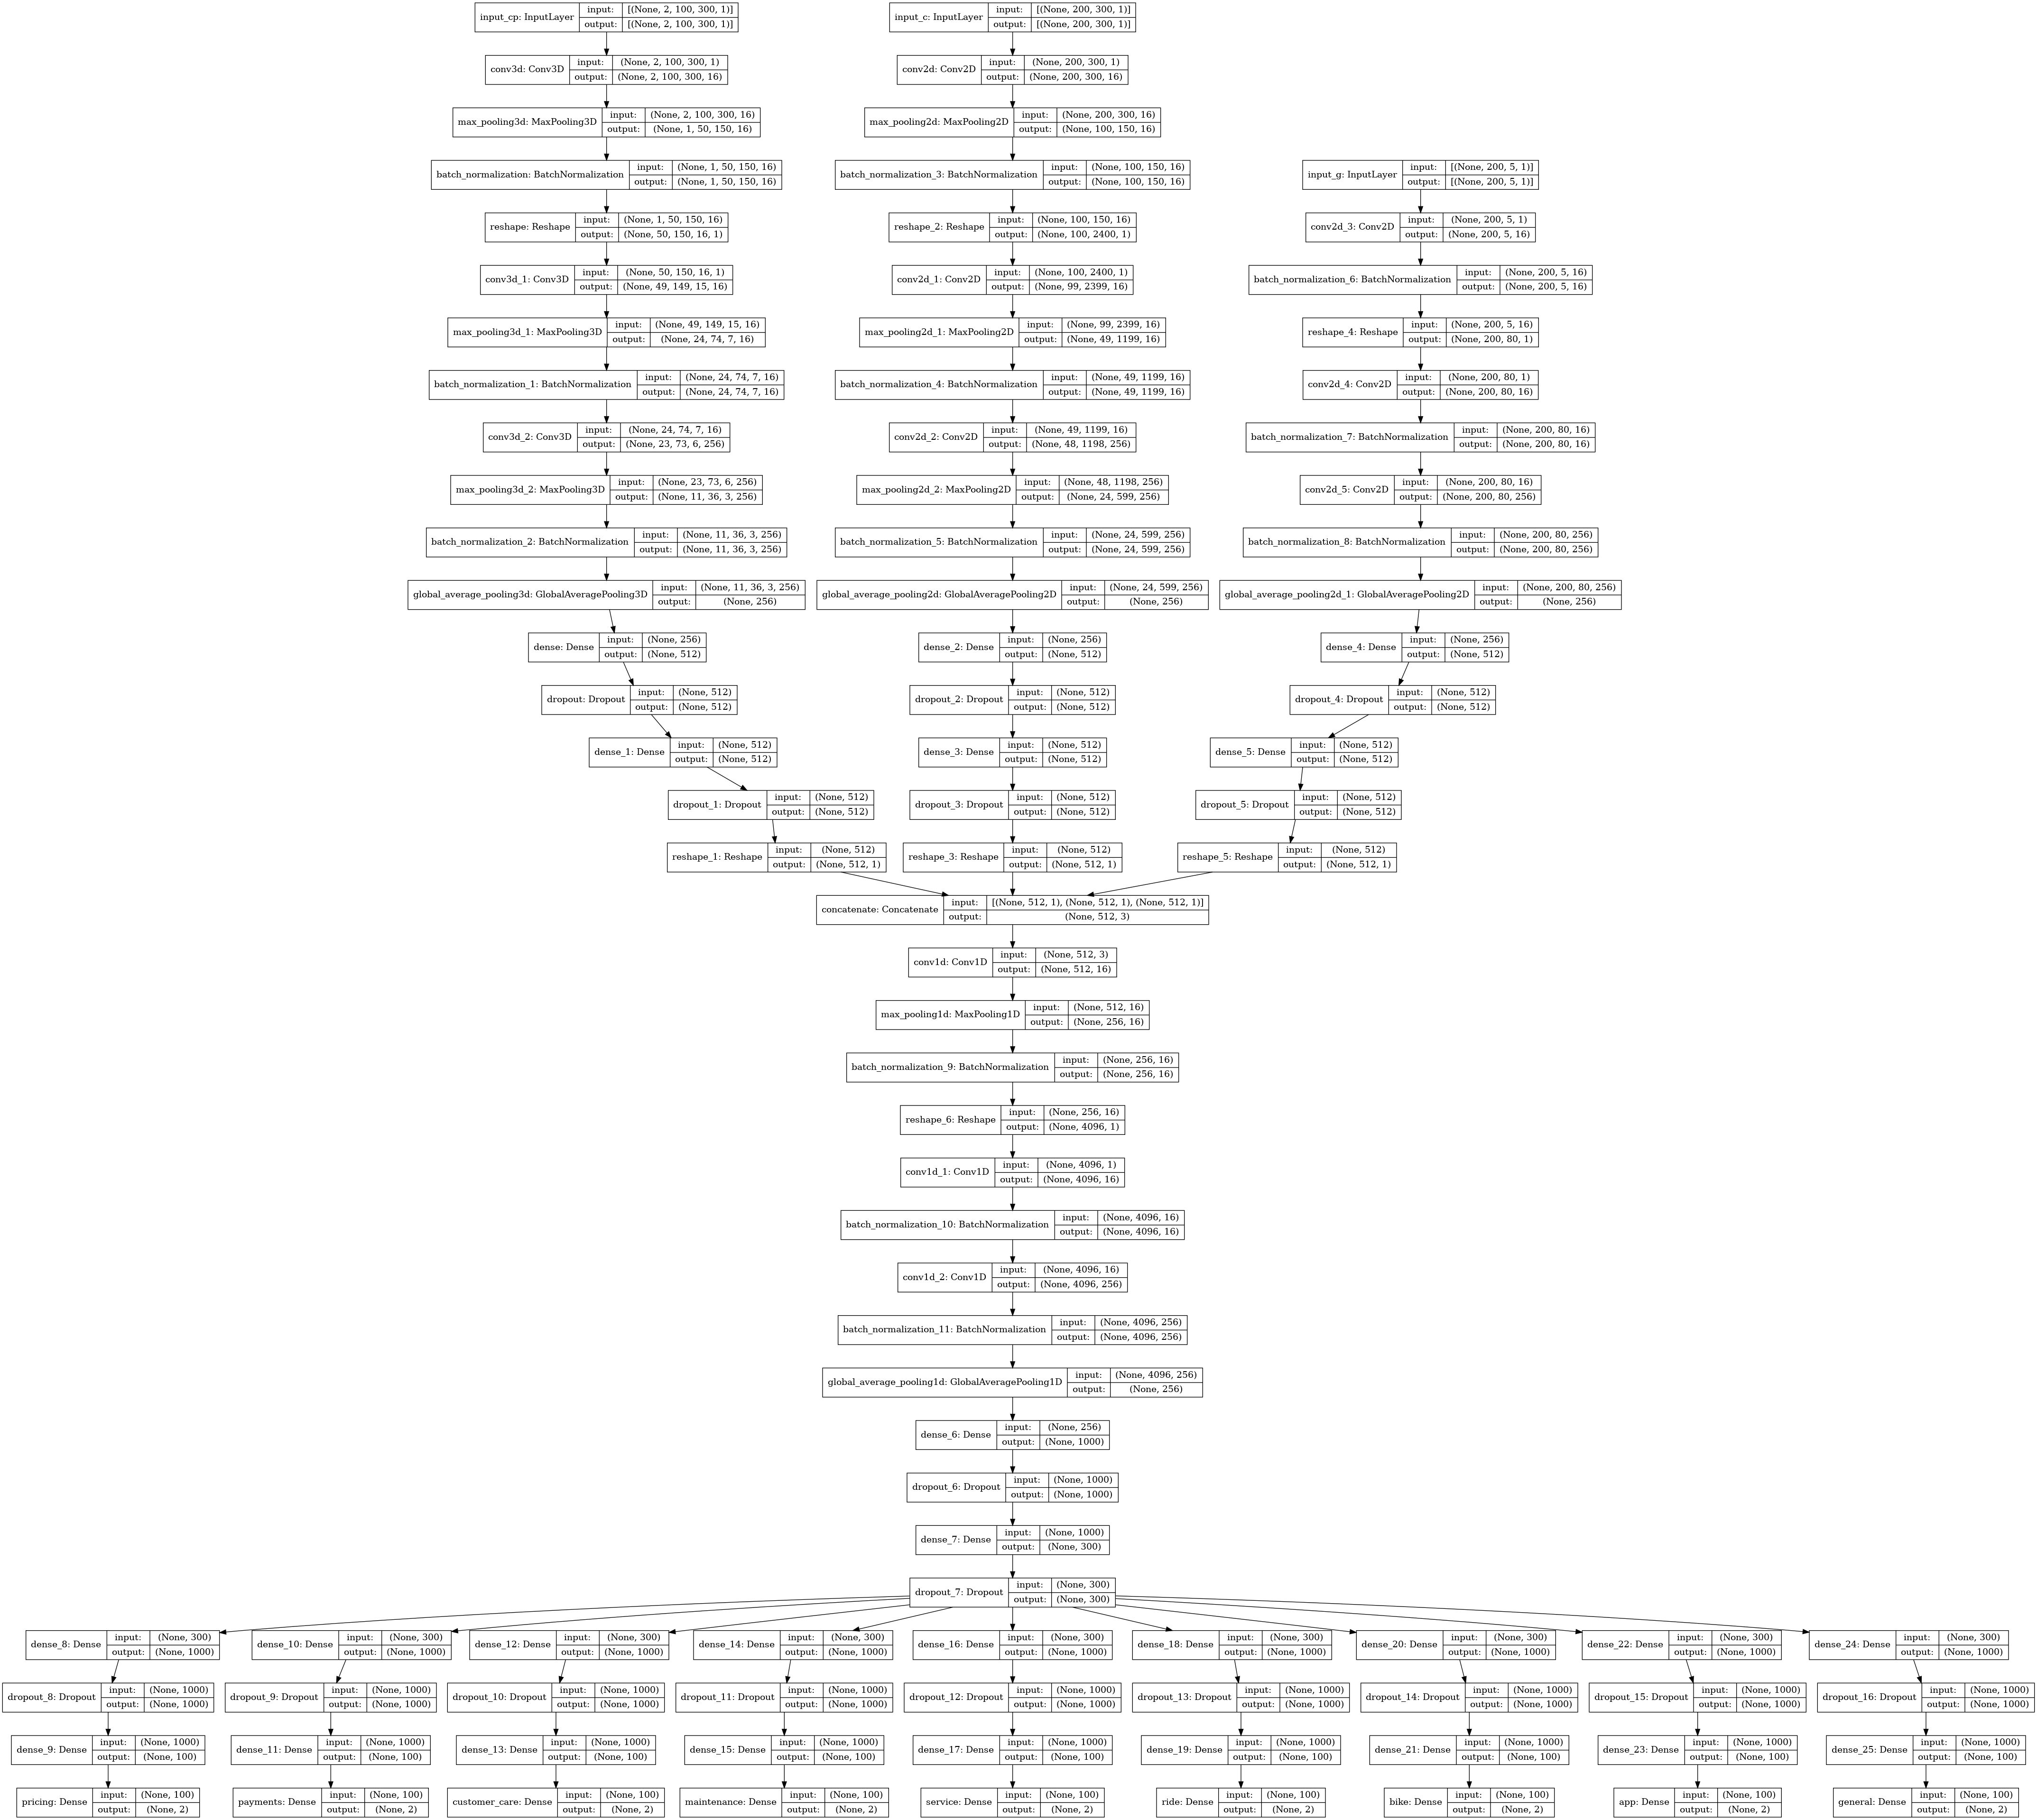

In [23]:
tf.keras.utils.plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    #show_dtype=True,
    #show_layer_names=True,
    #rankdir="LR",
    expand_nested=False,
    #dpi=96,
    layer_range=None,
)

In [24]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=[
        'accuracy',
        #tf.keras.metrics.AUC(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        #tf.keras.metrics.TruePositives(),
        #tf.keras.metrics.TrueNegatives(),
        #tf.keras.metrics.FalsePositives(),
        #tf.keras.metrics.FalseNegatives(),
        #tf.keras.metrics.BinaryAccuracy(),       
    ])

In [25]:
x = {
    'input_cp': X_cp,
    'input_c': X_c,
    'input_g': X_g
}

In [26]:
model.summary()

Model: "classifier"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cp (InputLayer)           [(None, 2, 100, 300, 0                                            
__________________________________________________________________________________________________
input_c (InputLayer)            [(None, 200, 300, 1) 0                                            
__________________________________________________________________________________________________
conv3d (Conv3D)                 (None, 2, 100, 300,  32          input_cp[0][0]                   
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 200, 300, 16) 32          input_c[0][0]                    
_________________________________________________________________________________________

In [27]:
%%time
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
rlrop = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=20)
es = EarlyStopping(monitor='val_loss', patience=100)
history = model.fit(
    x,
    y_, 
    epochs=1000, 
    verbose = 1,
    validation_split = 0.2,
    #validation_data=(test_x, test_y), 
    callbacks=[rlrop, es, tensorboard_callback], 
    #class_weight=class_weights
)

Epoch 1/1000


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[32,256,48,1198] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node classifier/conv2d_2/Relu (defined at <timed exec>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[assert_greater_equal_4/Assert/AssertGuard/pivot_f/_83/_389]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  OOM when allocating tensor with shape[32,256,48,1198] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node classifier/conv2d_2/Relu (defined at <timed exec>:5) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_14118]

Function call stack:
train_function -> train_function


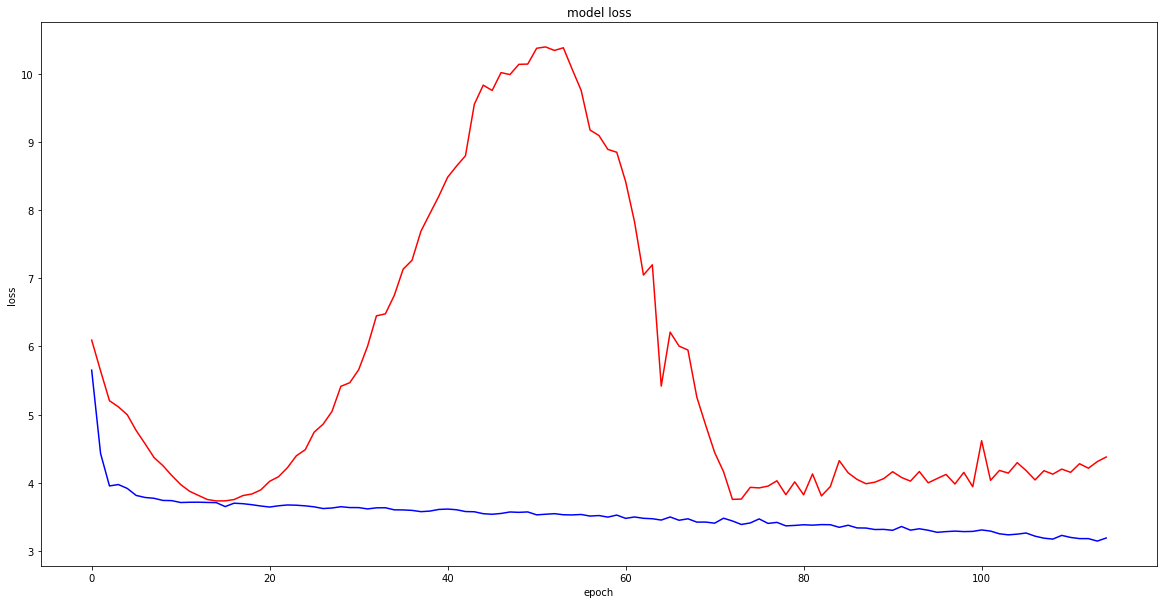

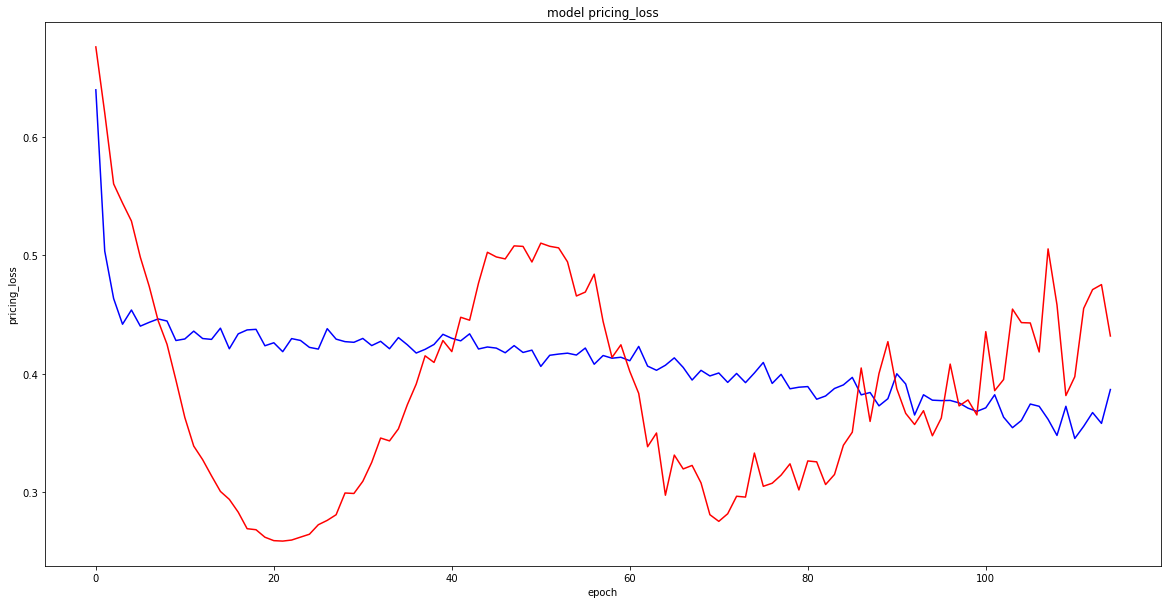

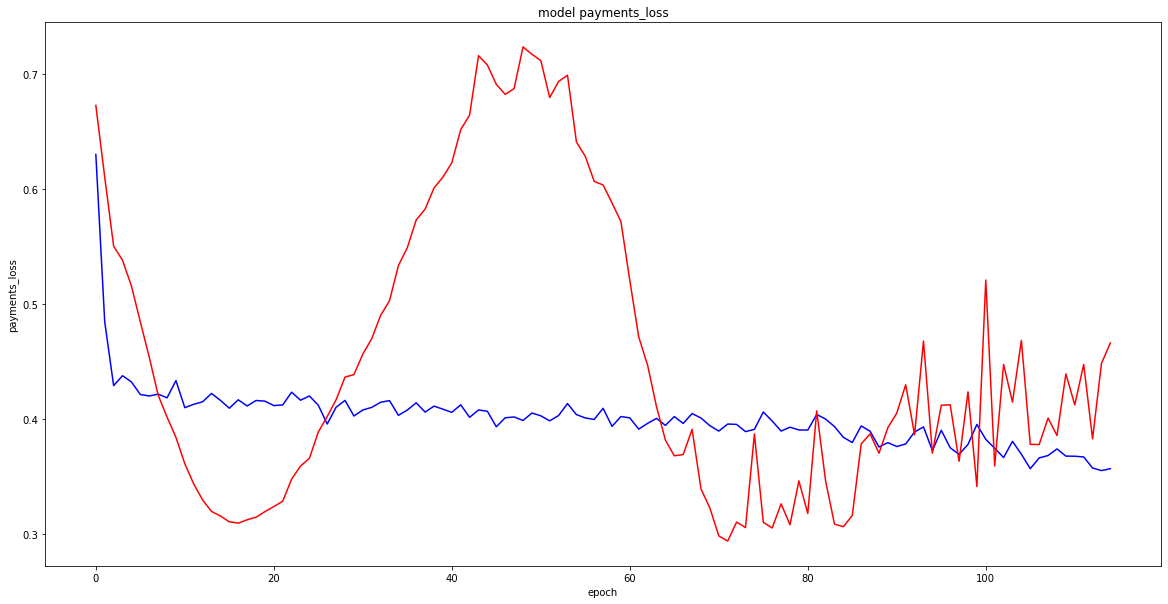

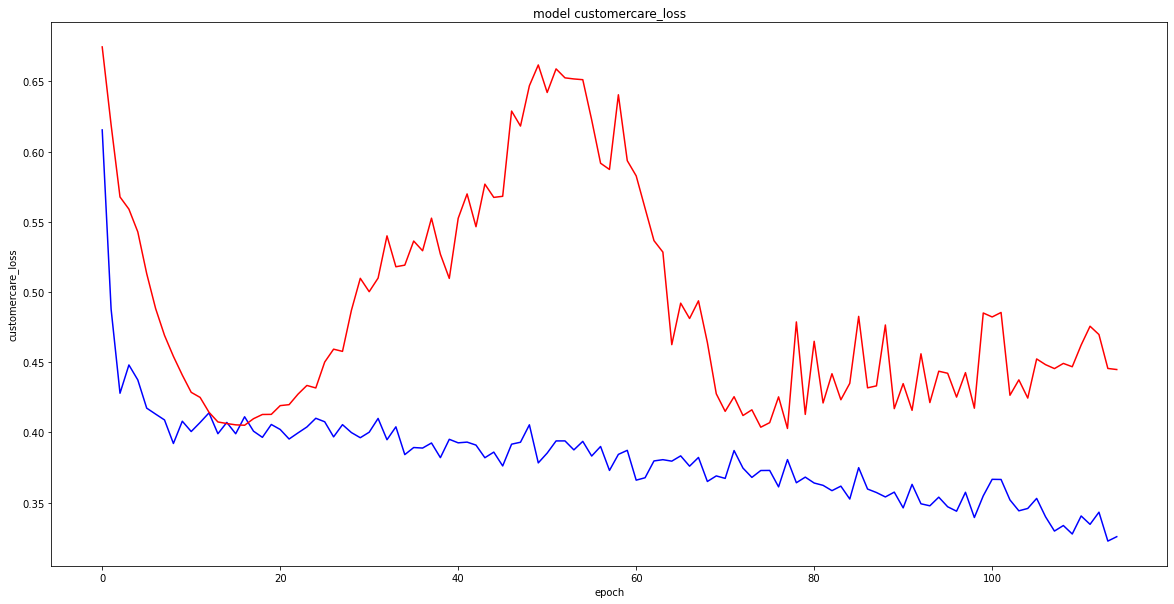

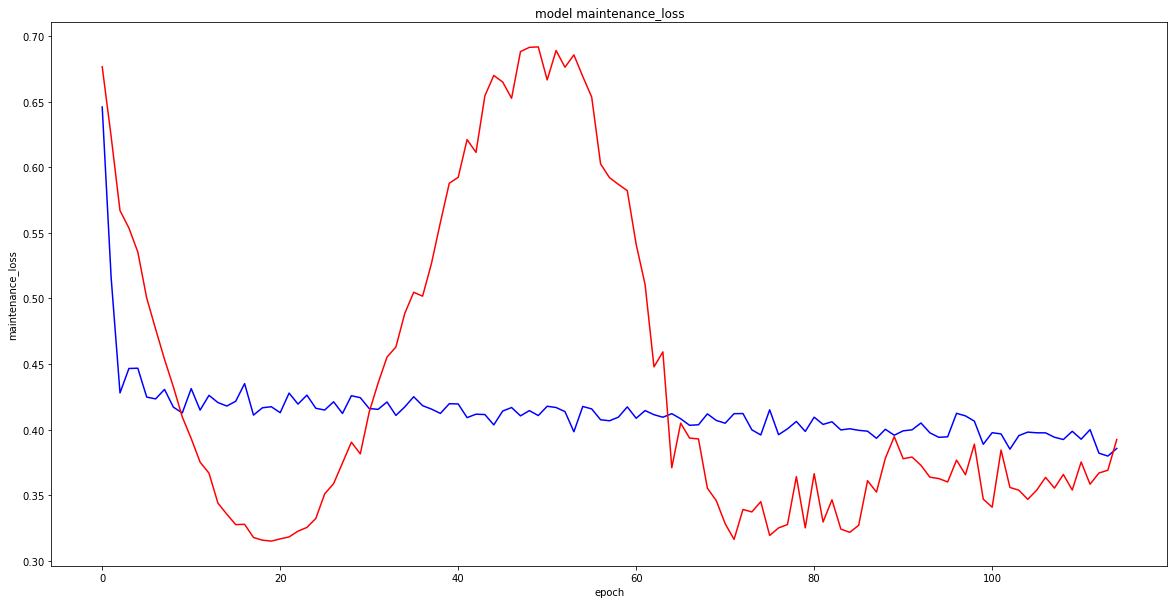

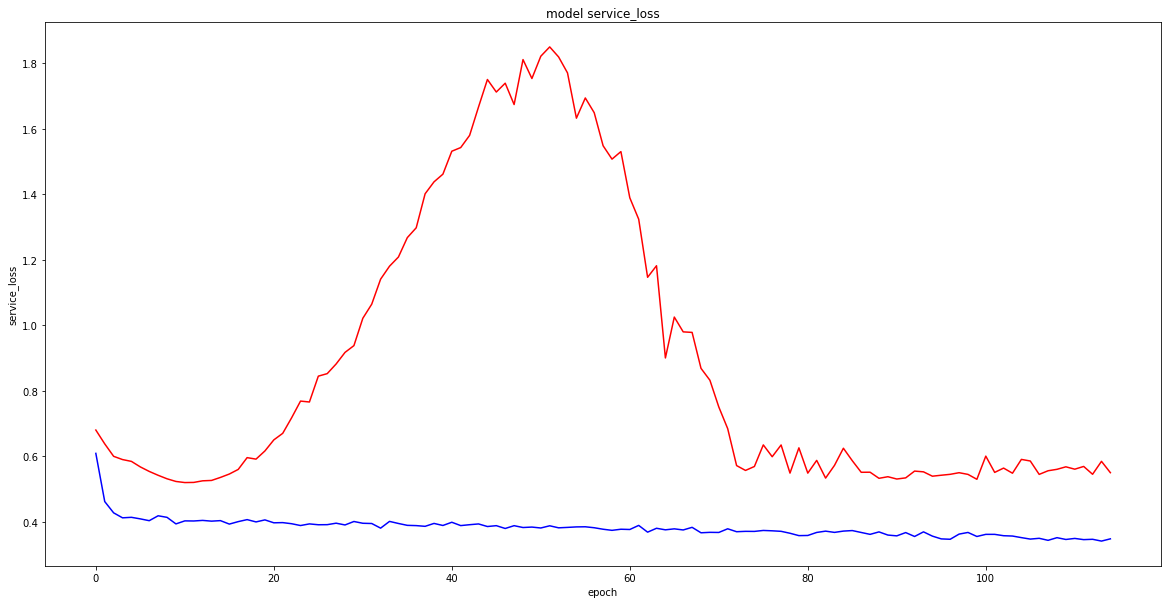

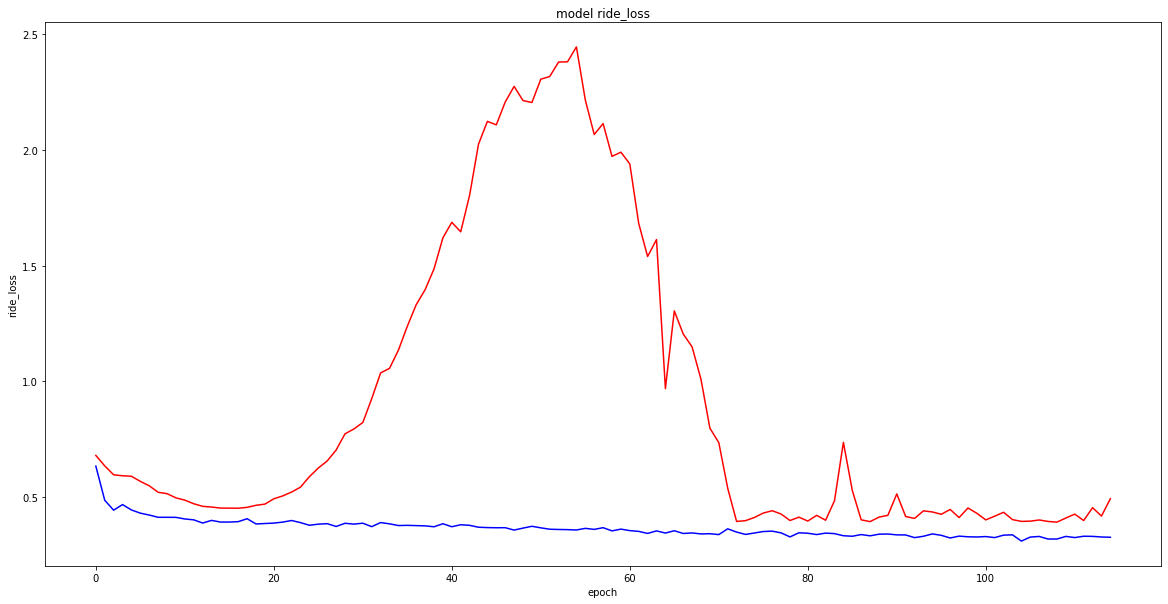

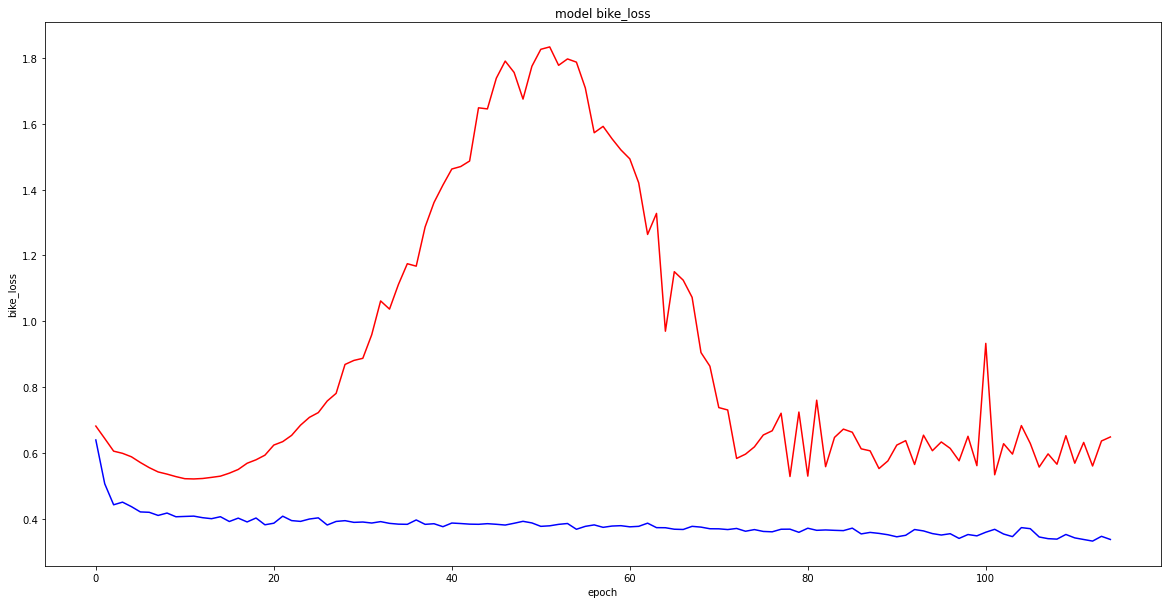

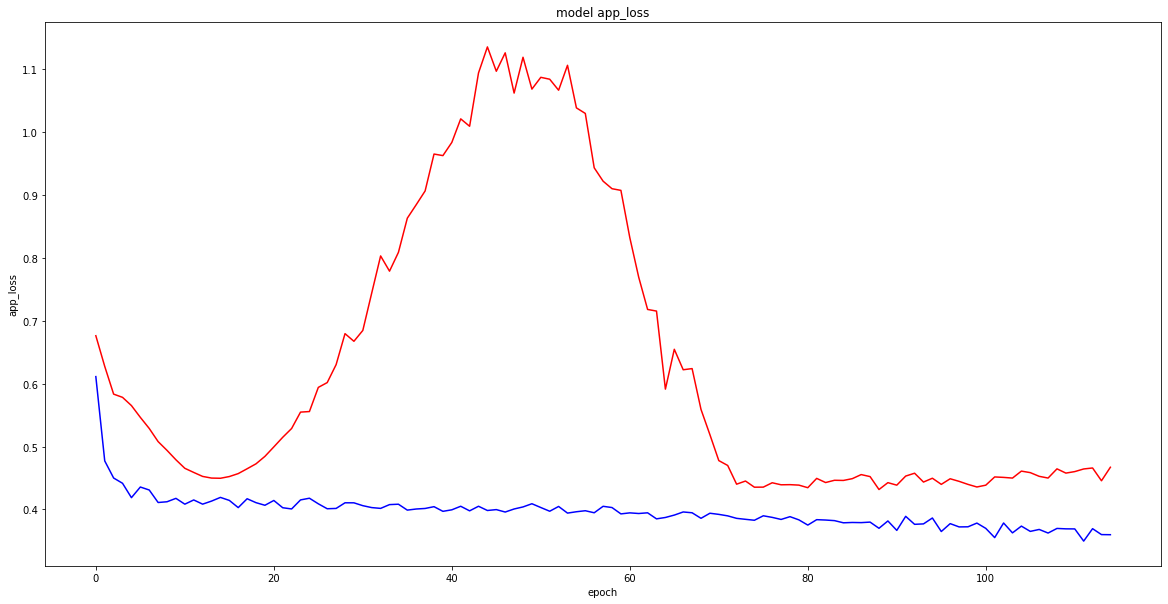

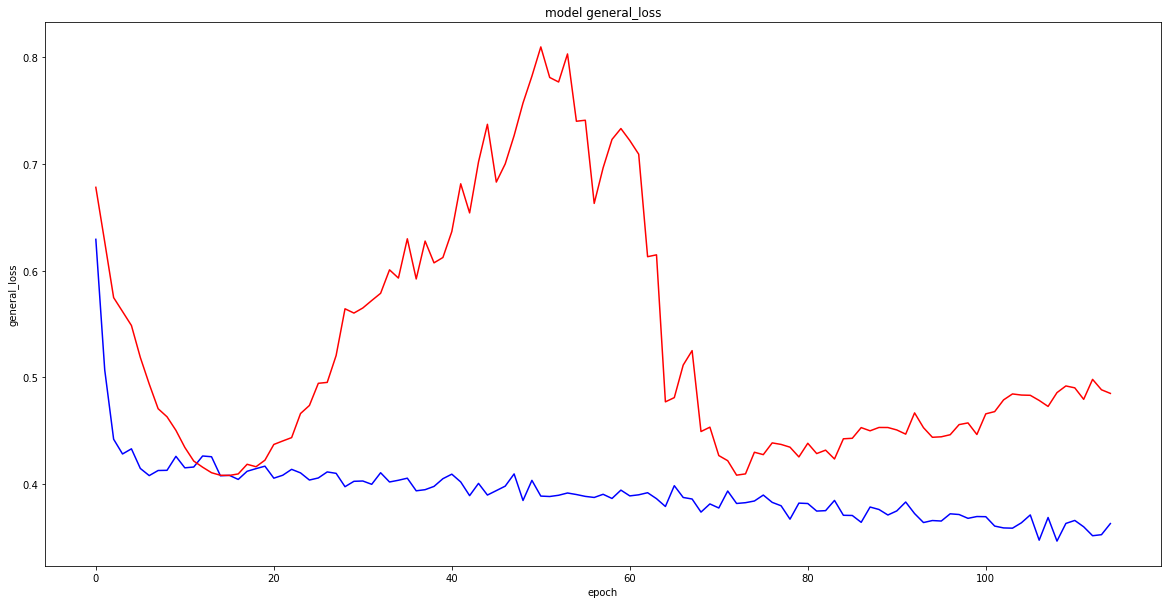

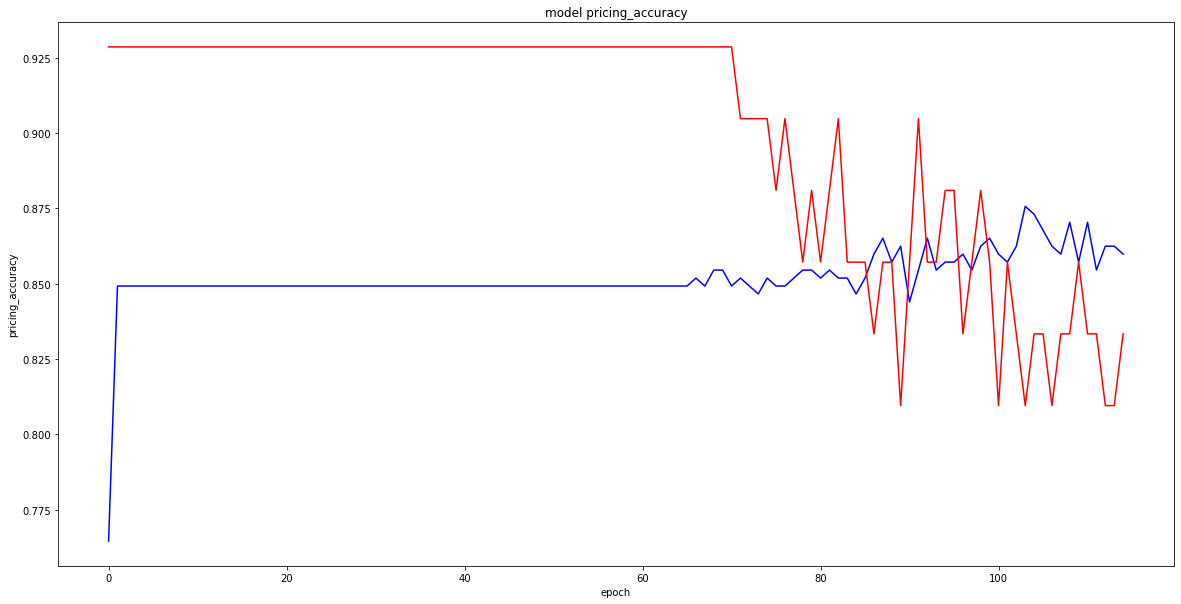

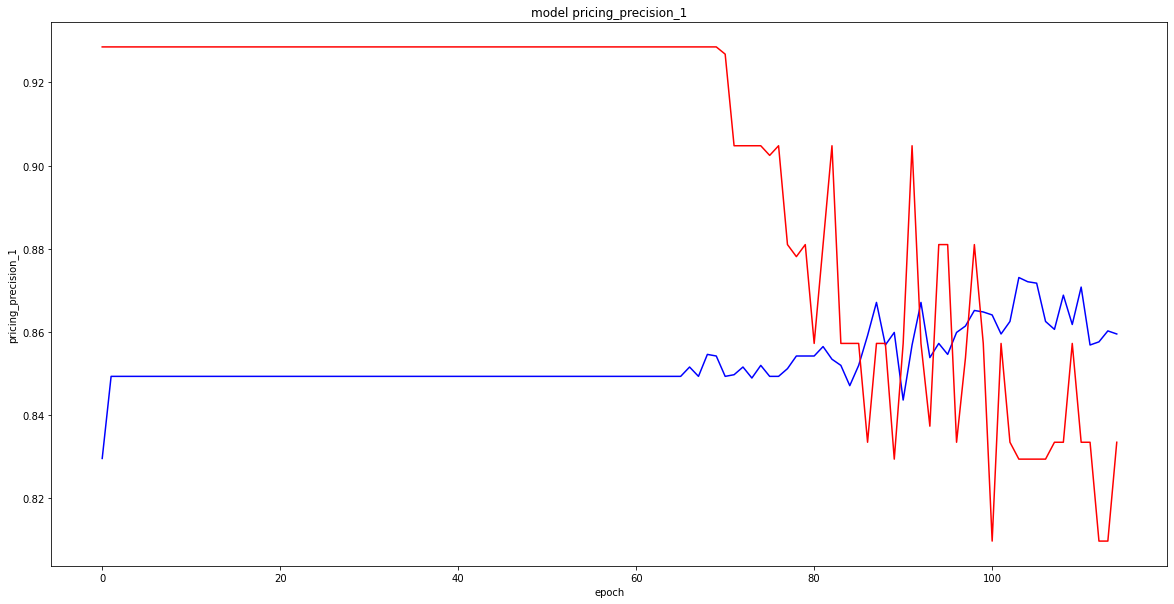

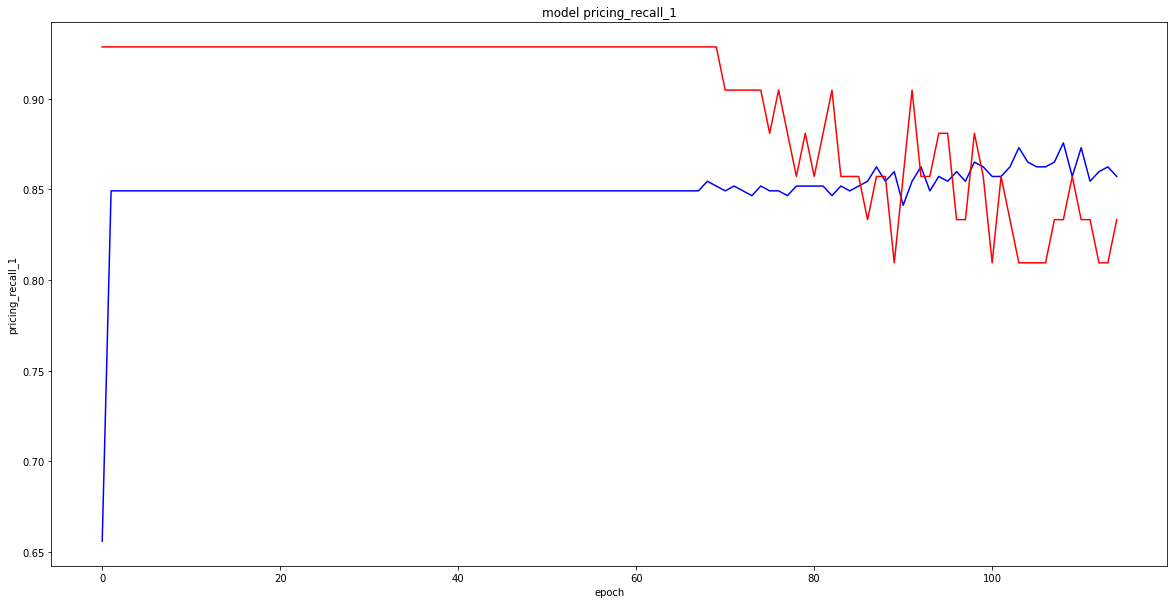

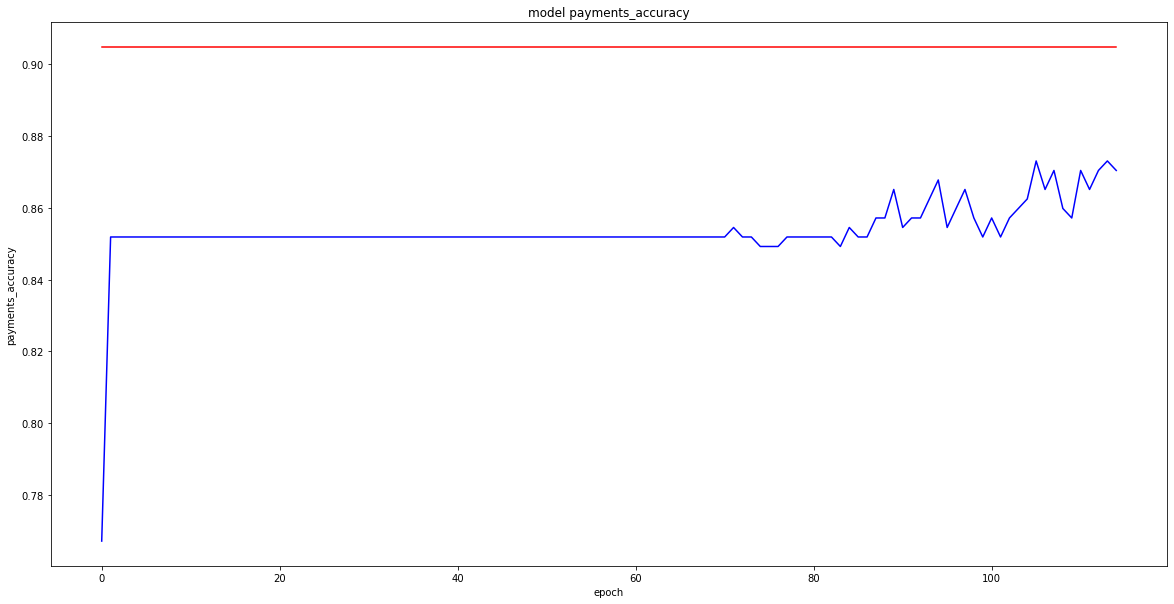

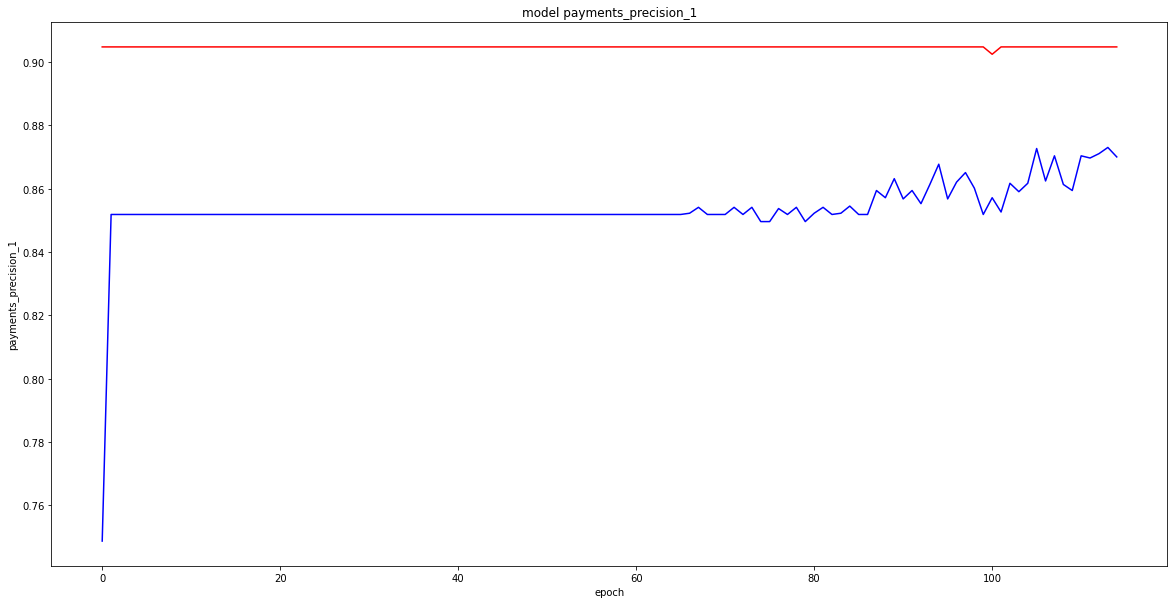

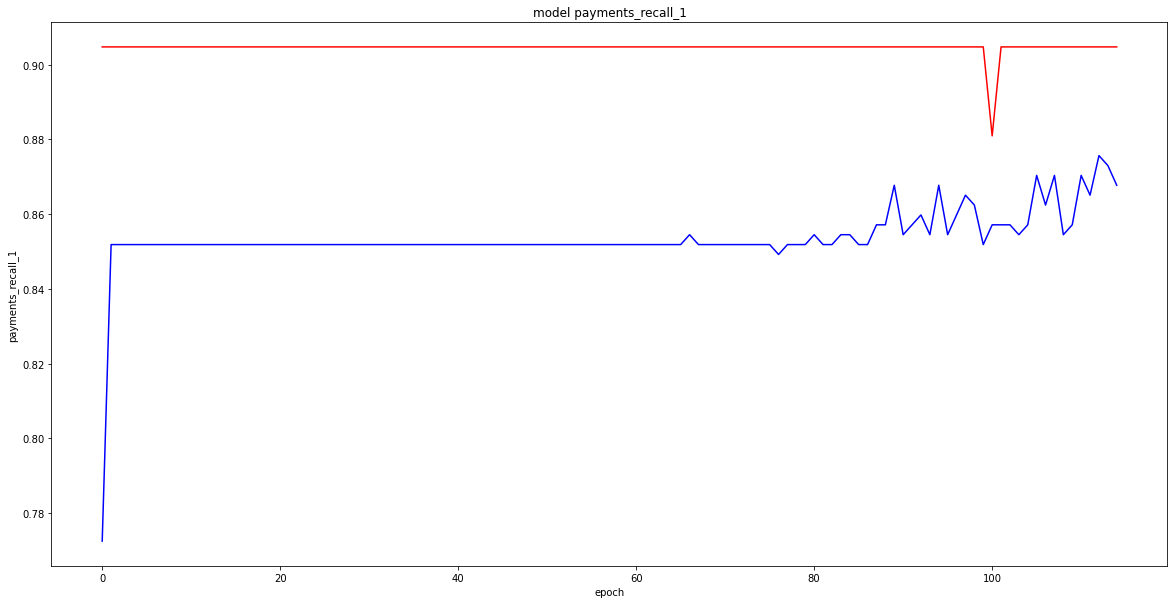

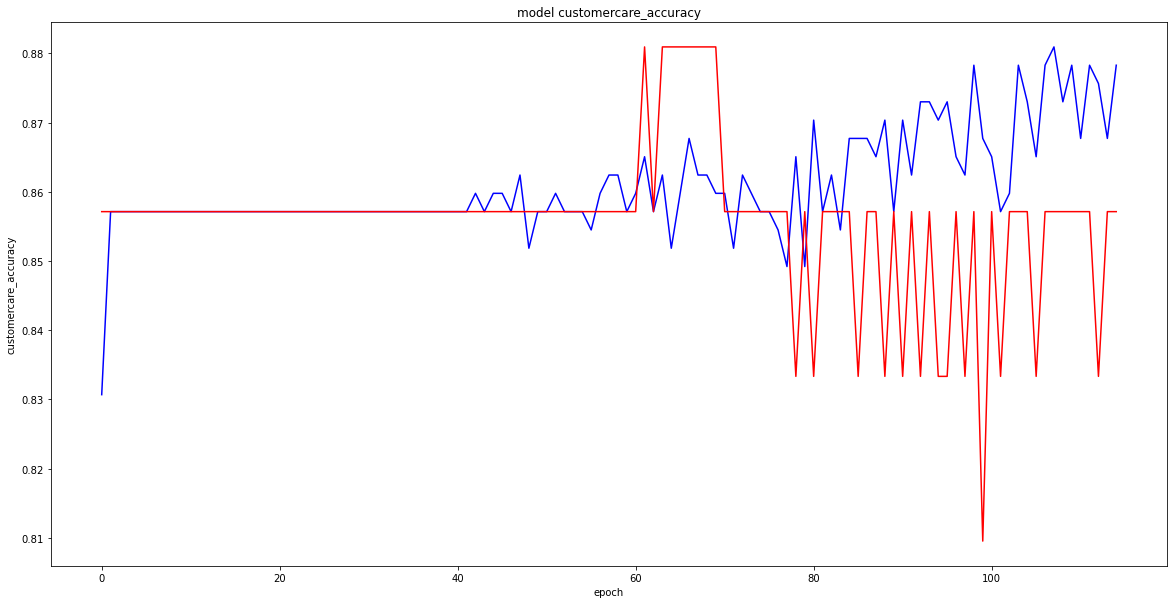

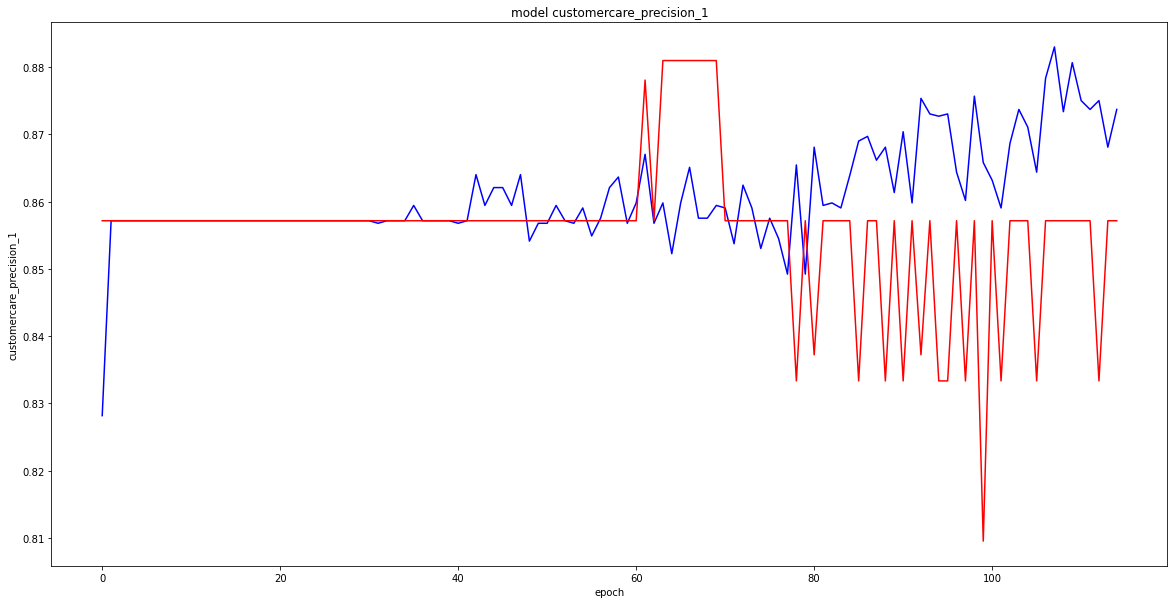

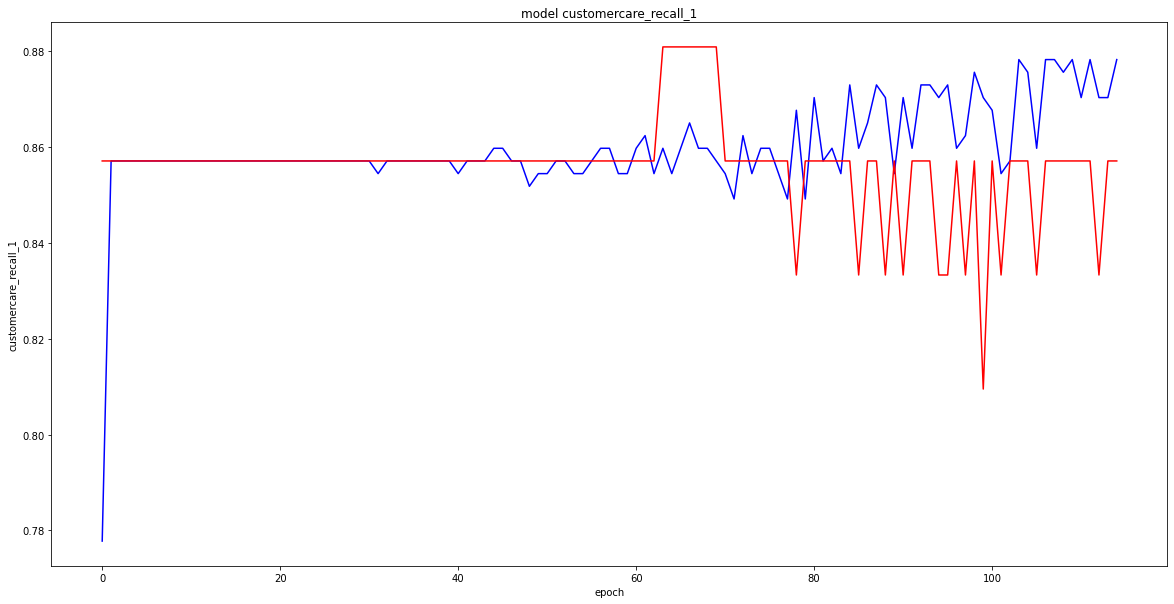

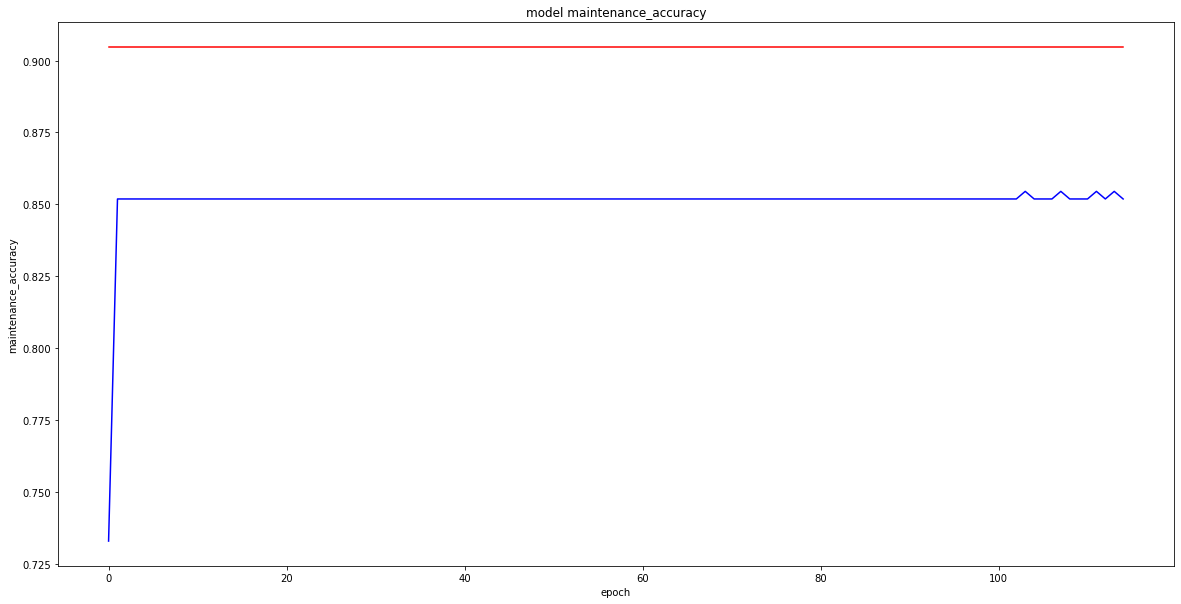

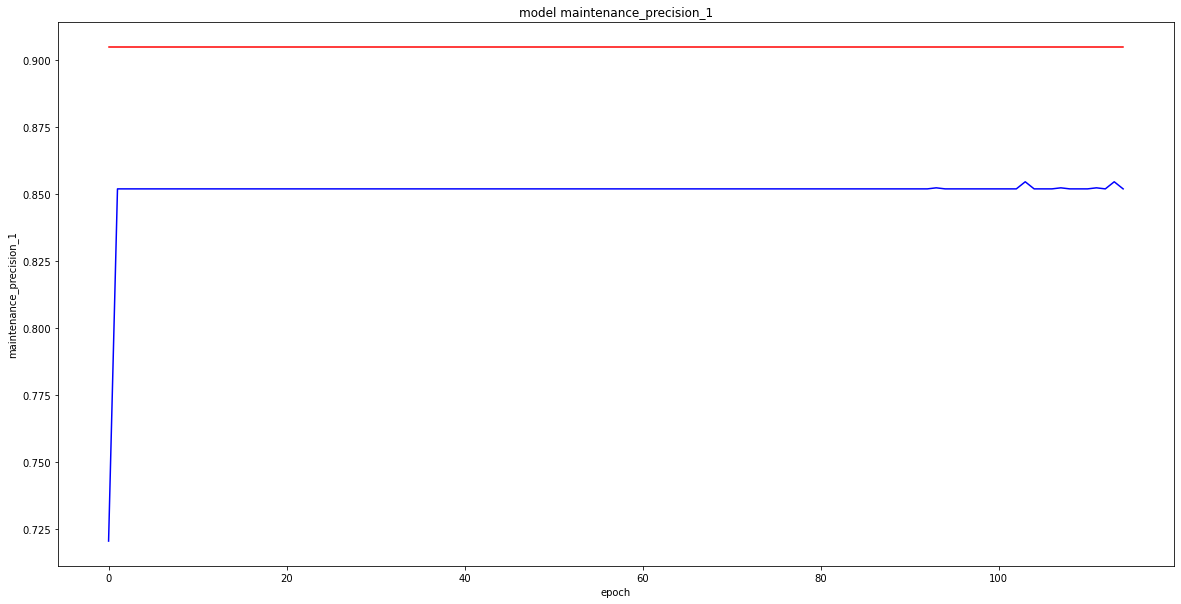

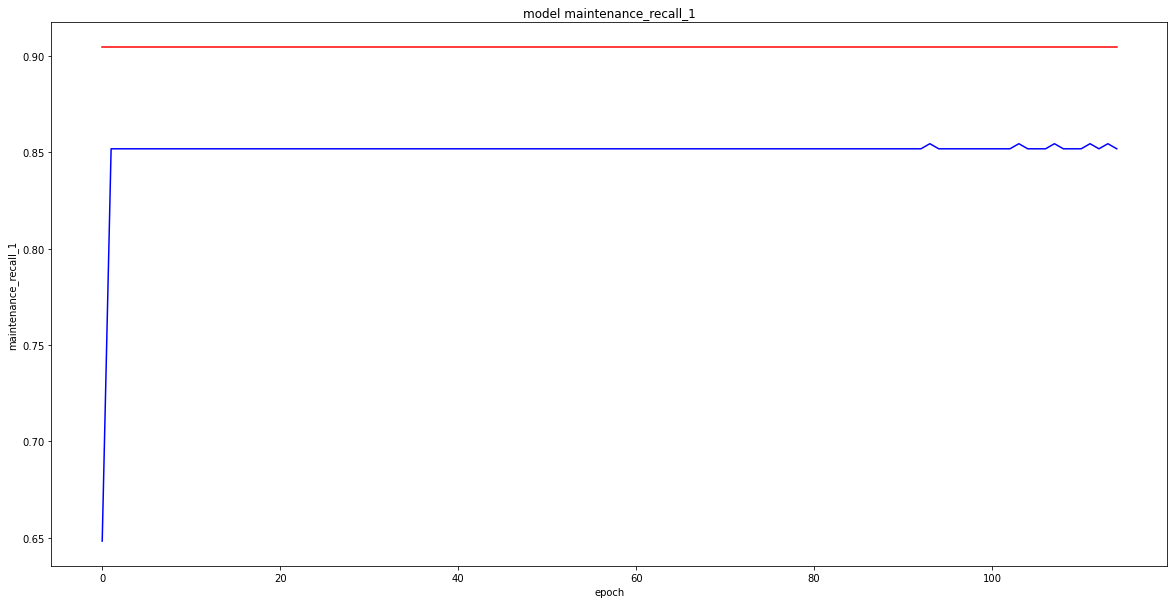

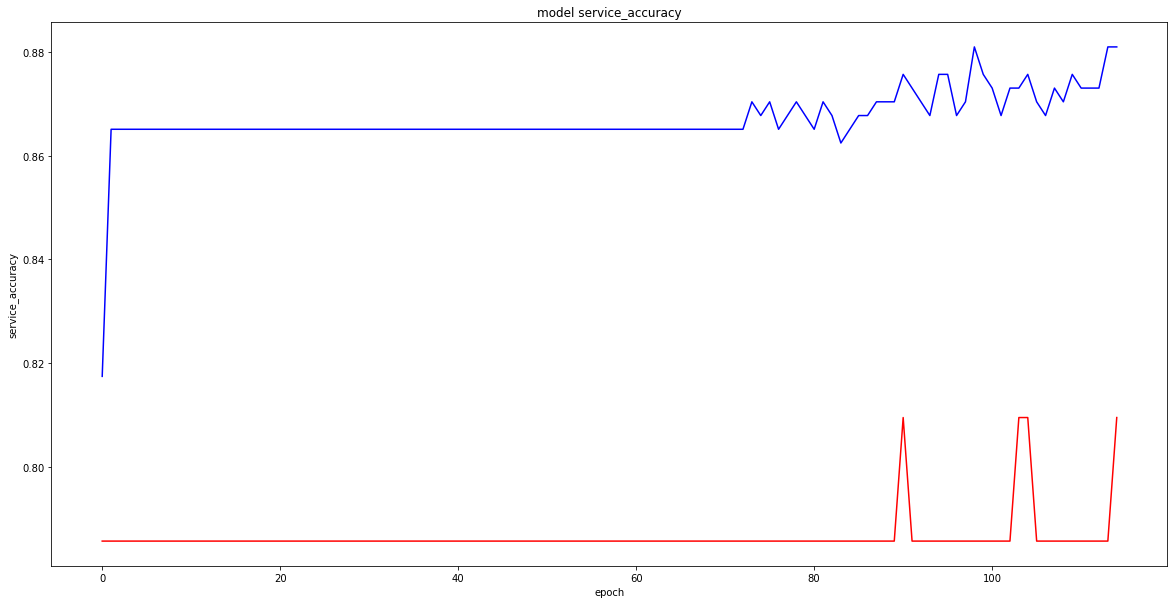

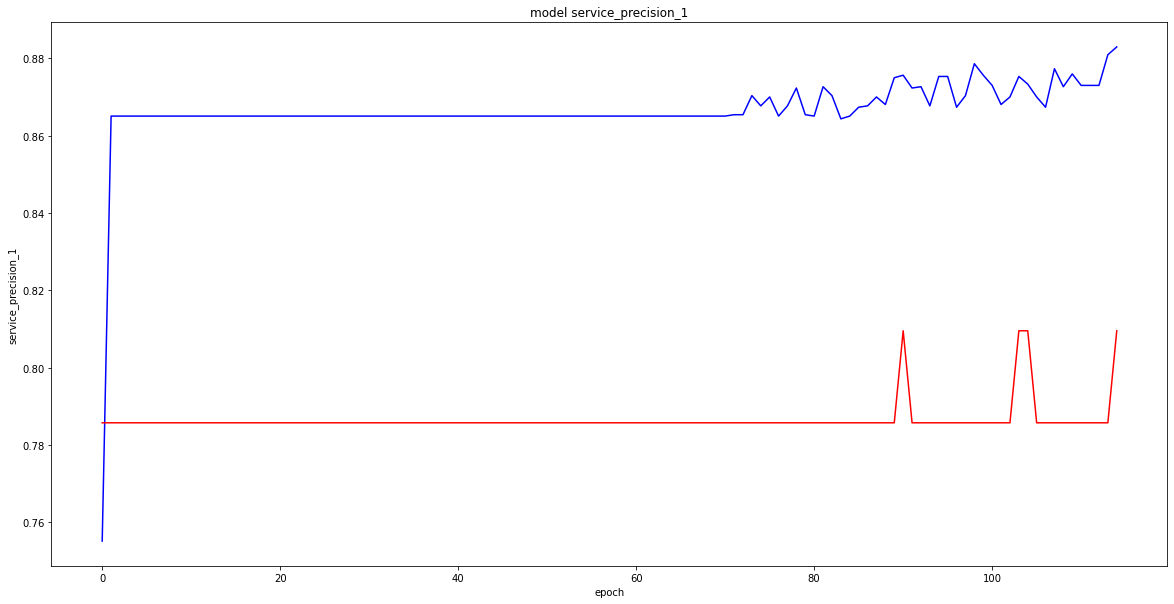

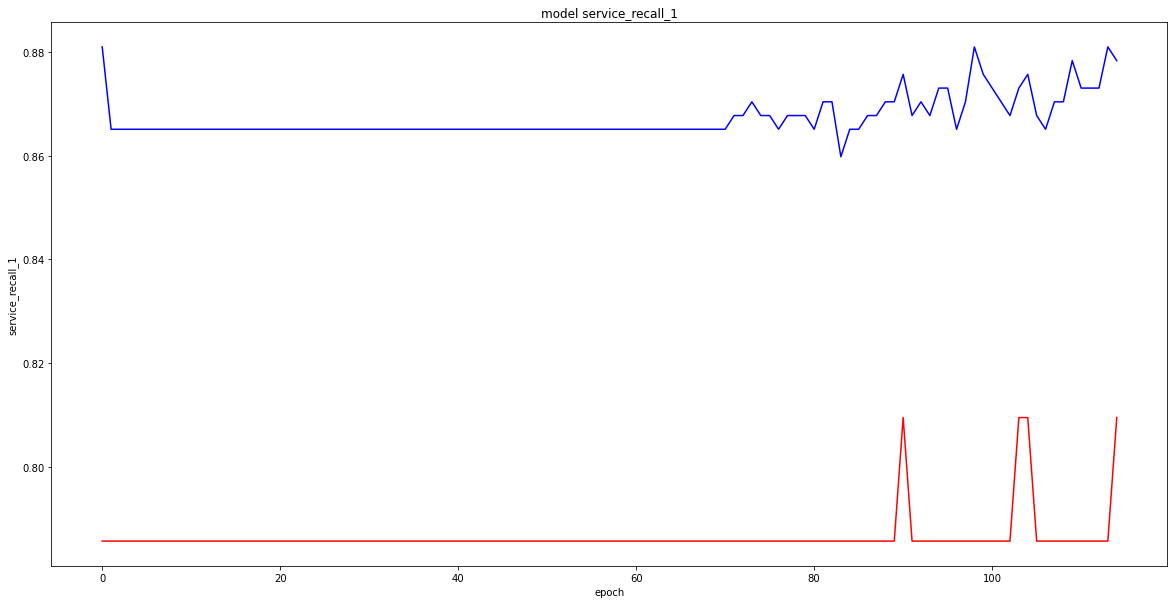

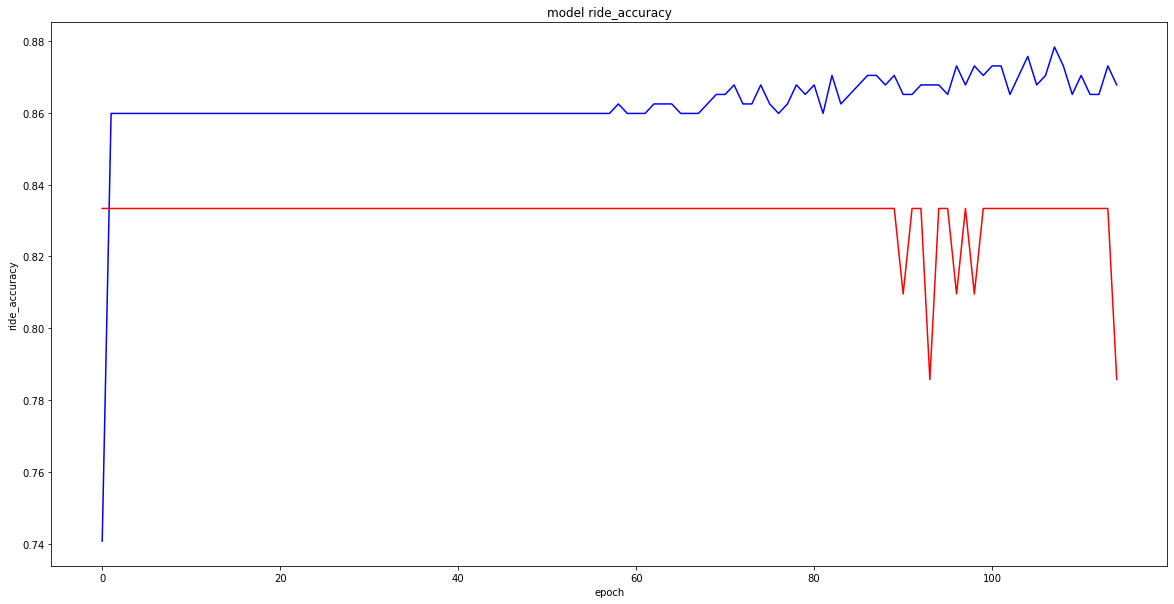

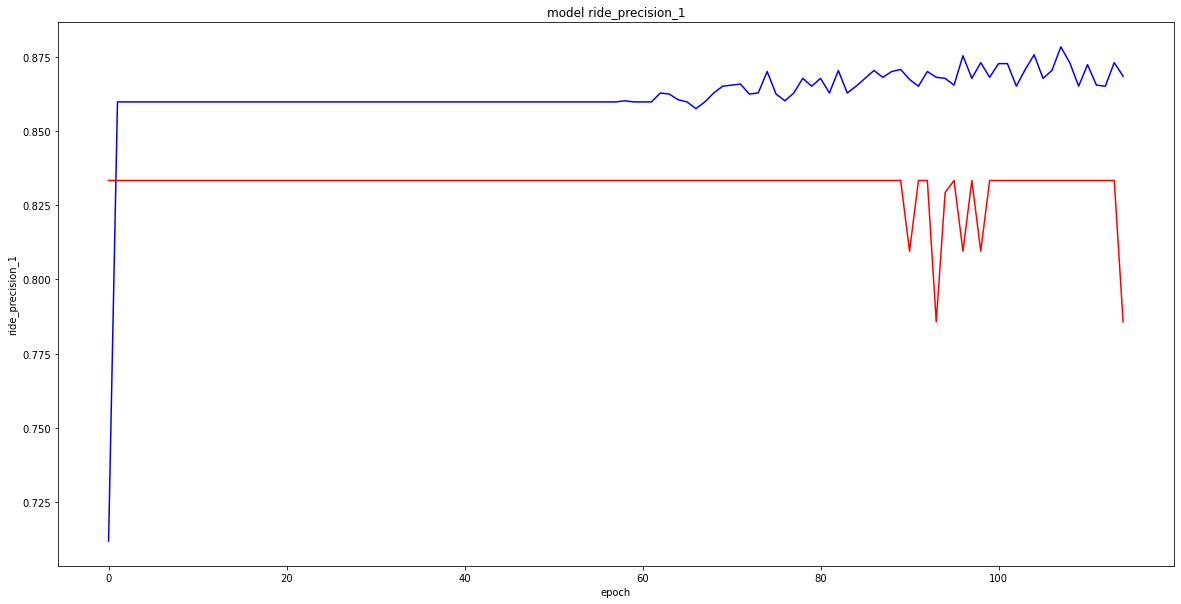

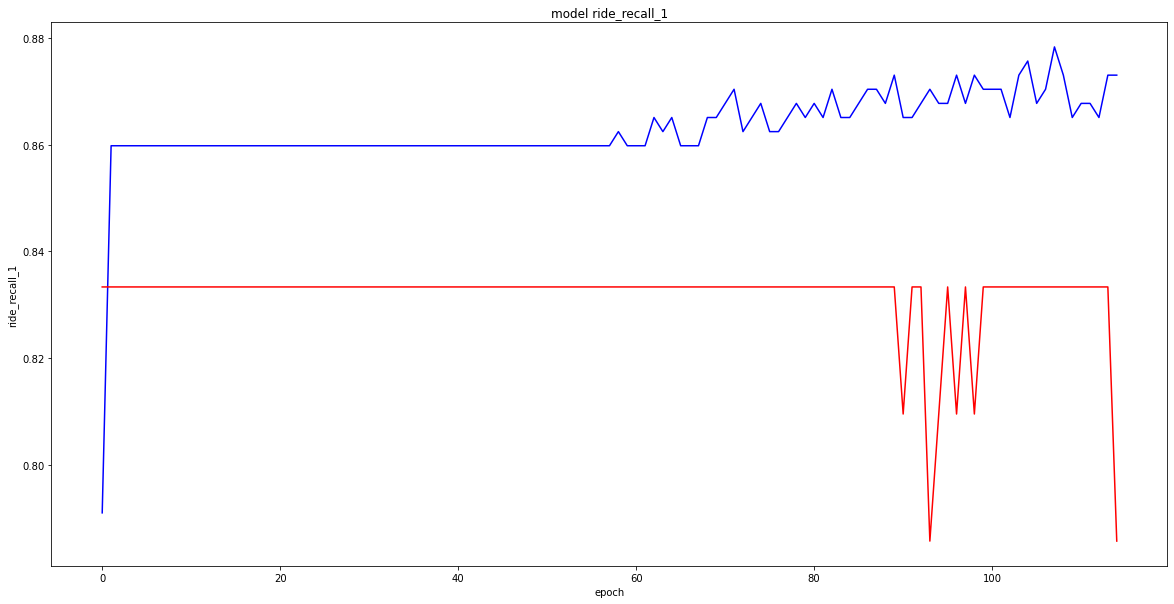

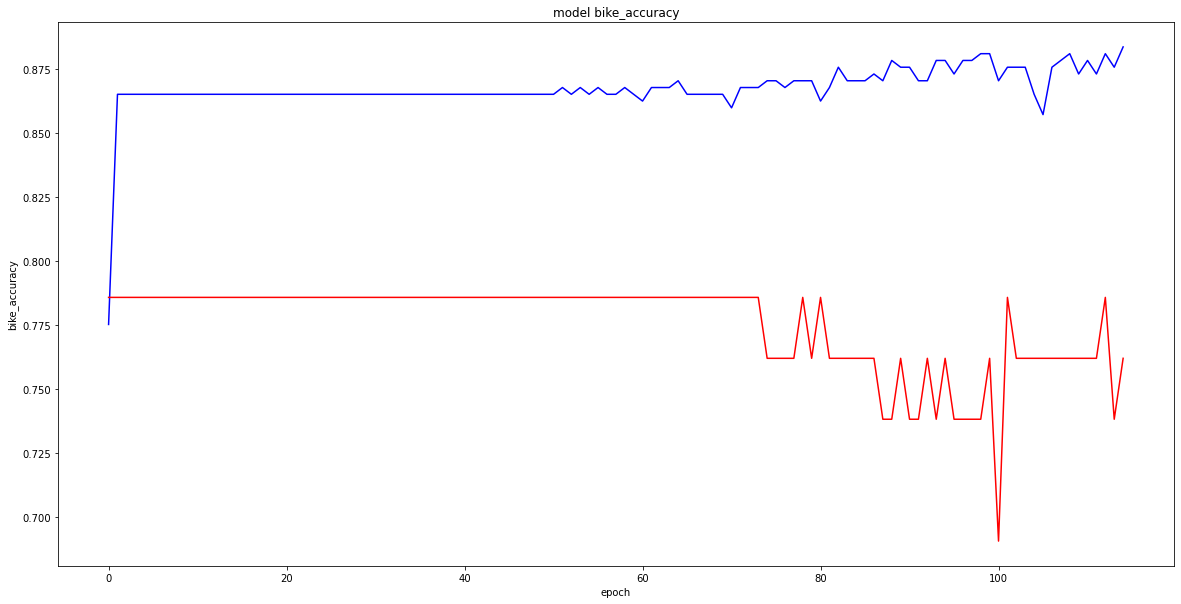

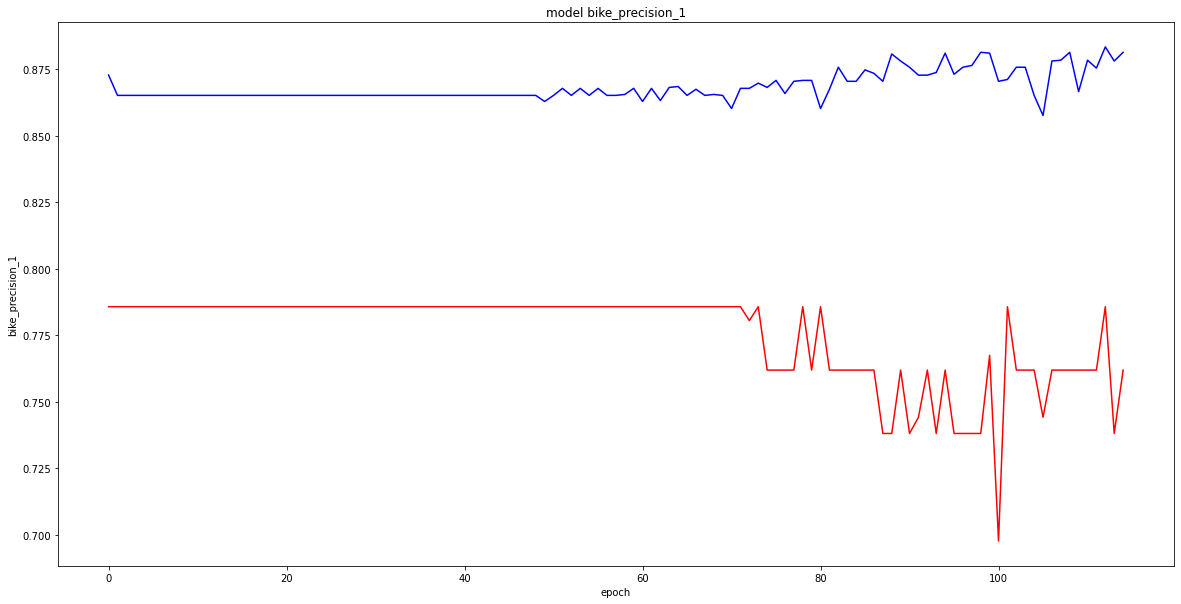

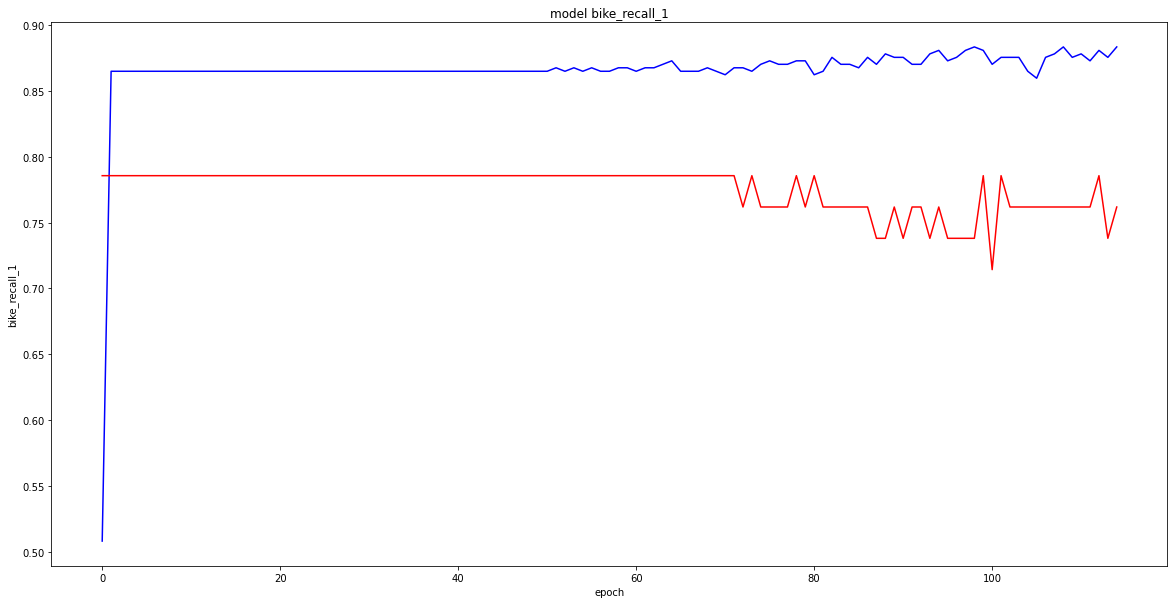

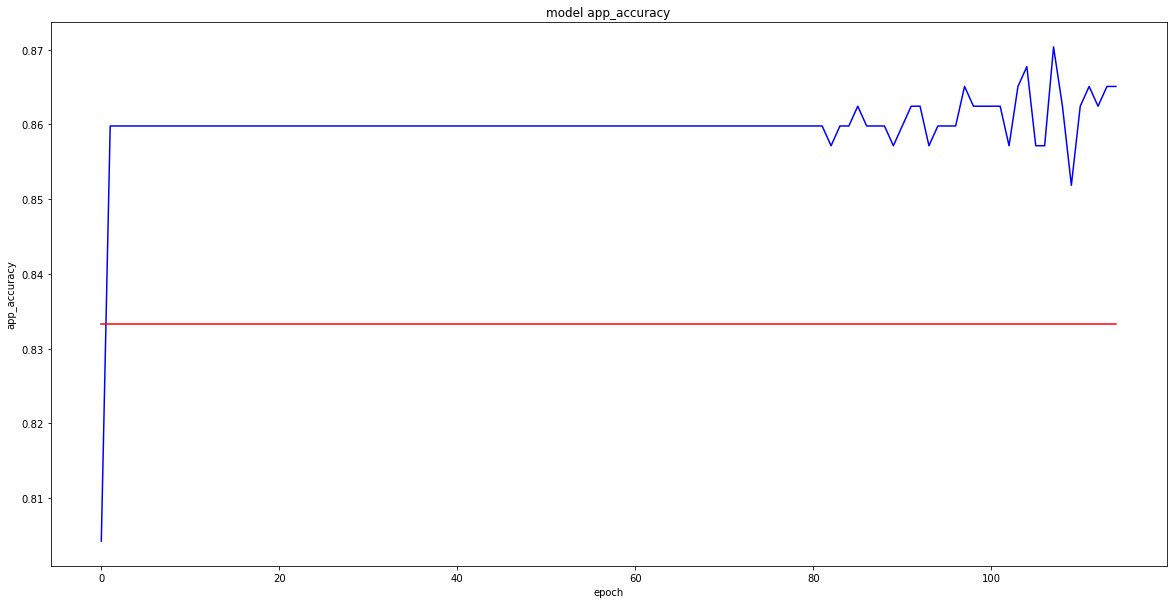

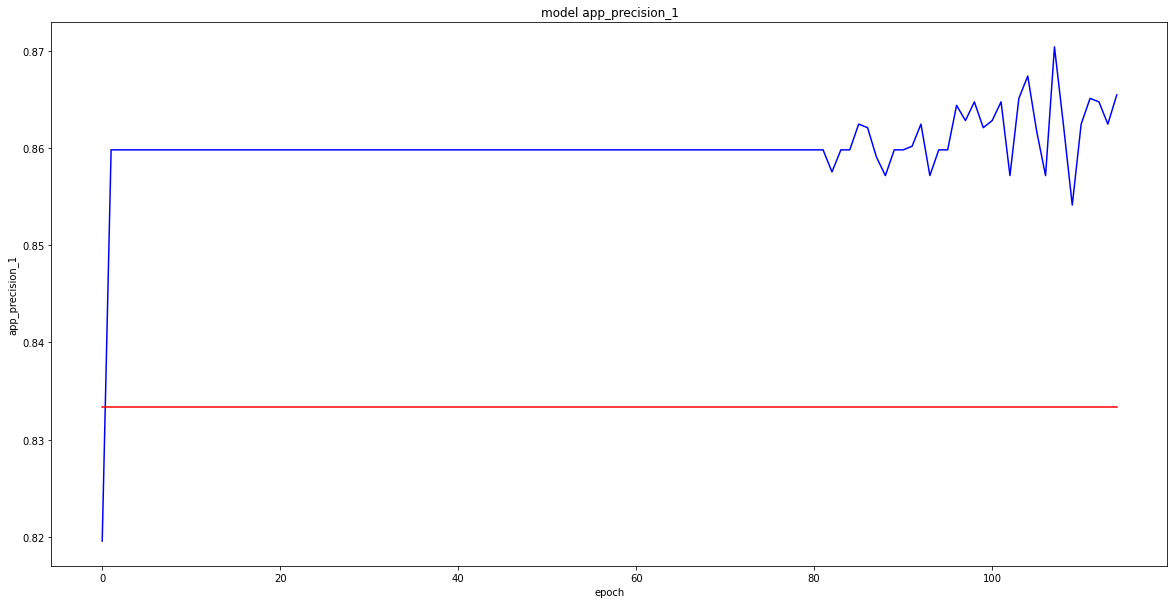

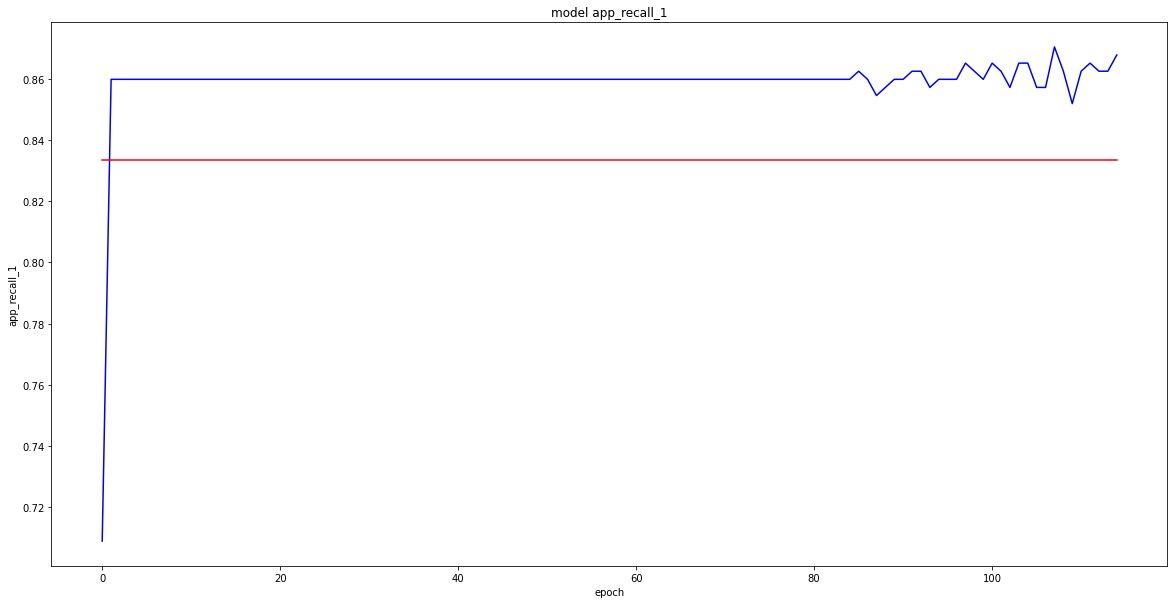

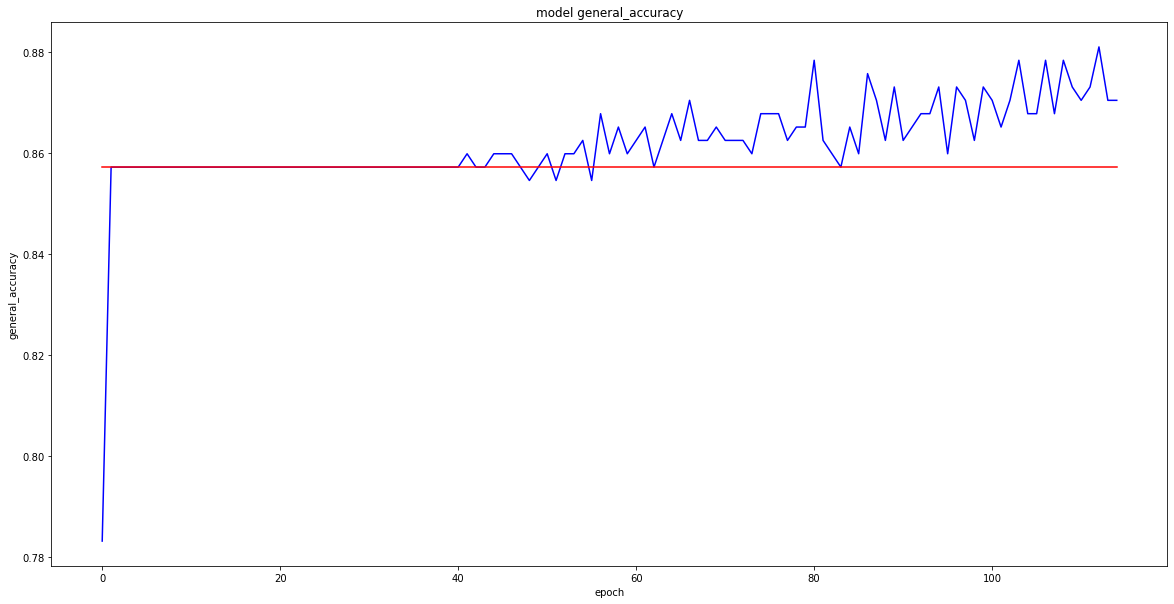

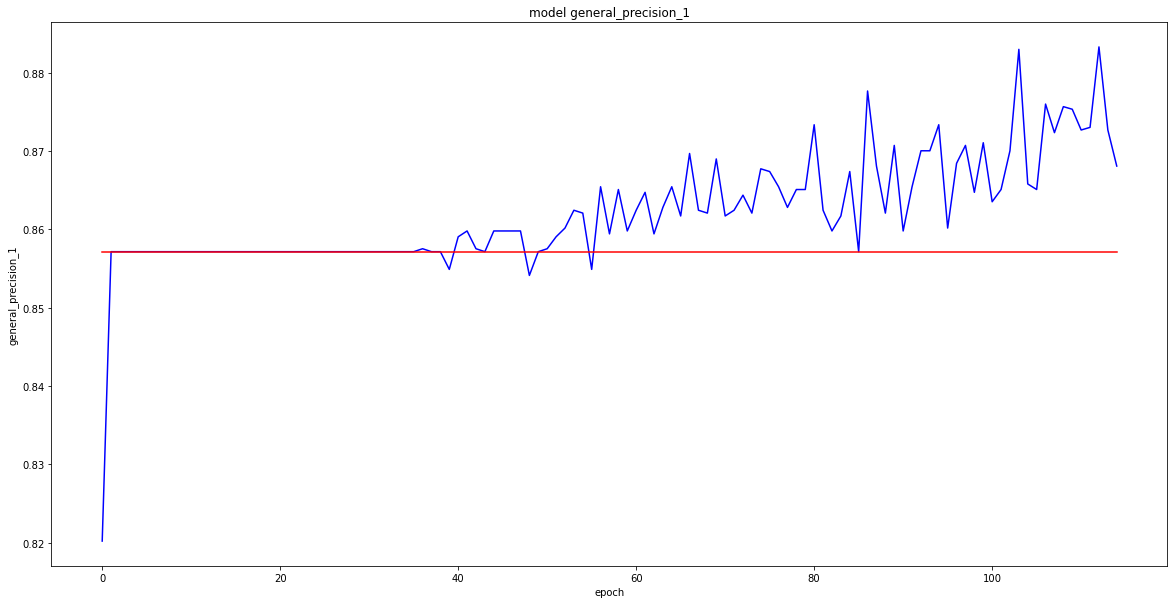

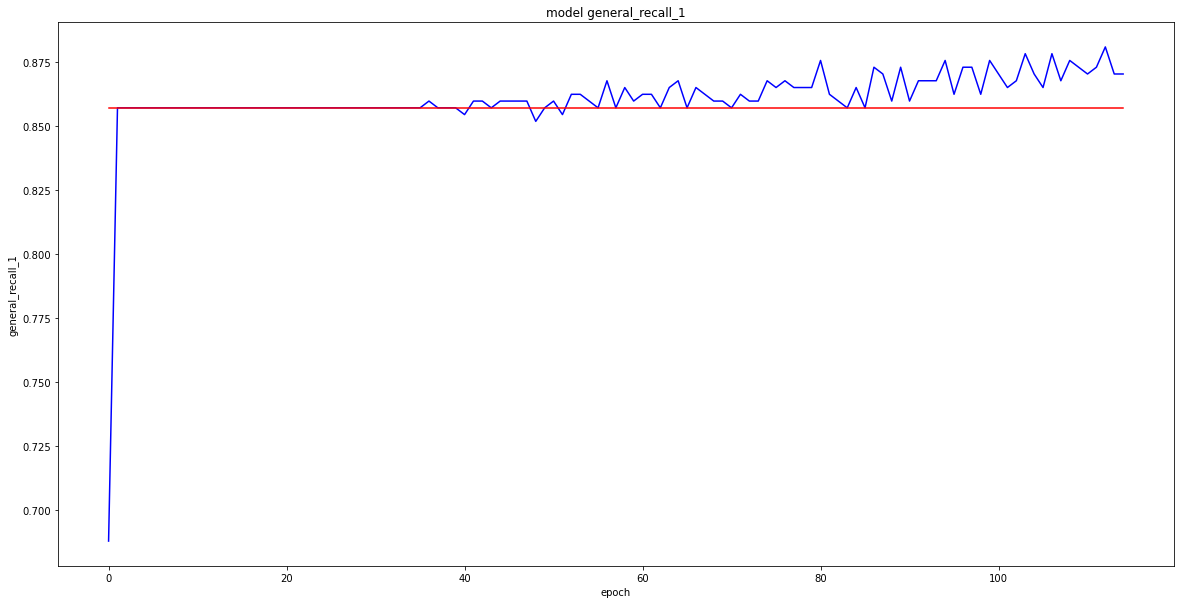

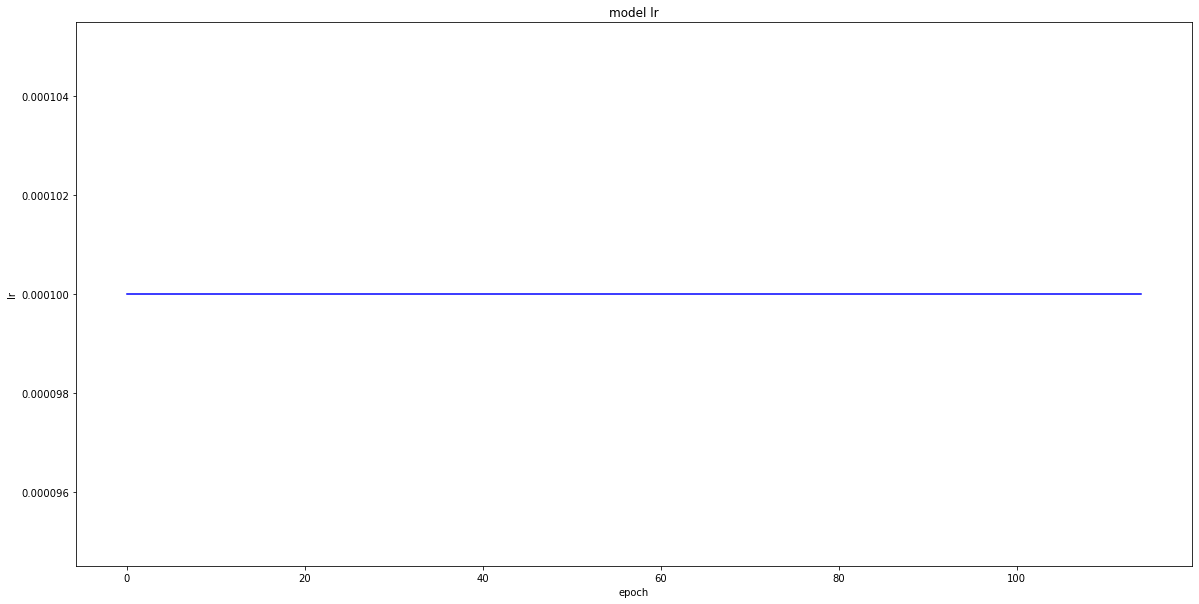

In [212]:
for key in history.history.keys():
    if key[:4] != 'val_' and key != 'lr':
        plt.figure(figsize=(20,10))
        plt.plot(history.history[key], color = 'b')
        plt.plot(history.history['val_' + key], color = 'r')
        plt.title('model ' + key)
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.show()
    elif key == 'lr':
        plt.figure(figsize=(20,10))
        plt.plot(history.history[key], color = 'b')
        plt.title('model ' + key)
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.show()

In [75]:
df1 = pd.read_excel('yulu_dataanalysis_bp.xlsx').fillna('').drop(['Unnamed: 0'], axis = 1)

In [85]:
df

,phrase list,pricing,payments,customercare,maintenance,service,ride,bike,app,general,cp_array
264,"[it ride, wa ride, wonderful ride]",False,False,False,False,False,True,False,False,False,"[[[0.0037171647, -0.24187279, -0.08966686, -0...."
14,"[it feature, good feature, affordable feature,...",True,False,False,False,False,False,False,True,False,"[[[0.0037171647, -0.24187279, -0.08966686, -0...."
127,"[receiving otp, helped customer, care customer]",False,False,True,False,False,False,False,True,False,"[[[-0.027935429, 0.02404166, 0.025613515, 0.03..."
386,"[end app, issue app, ride app, good idea, more...",False,False,False,False,False,False,False,False,True,"[[[-0.06802692, -0.004177347, 0.022744775, 0.2..."
364,"[best riding, app riding]",False,False,False,False,False,False,False,True,False,"[[[-0.115723416, 0.019766208, -0.17047718, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...
244,"[nice ghansoli, please ghansoli, mart ghansoli...",False,False,False,False,True,False,False,False,False,"[[[0.08967914, -0.16099322, -0.0023577227, 0.0..."
374,"[team app, ur app, ur app, work app, install a...",False,False,False,False,False,False,False,True,False,"[[[0.018866226, -0.0076524345, 0.009518319, 0...."
128,"[excellent support, service support, and custo...",False,False,True,False,True,False,False,False,False,"[[[-0.013077152, -0.020418543, -0.0060617253, ..."
343,"[open time, wasting time, me time, use start]",False,False,False,False,False,False,True,False,False,"[[[-0.041740753, -0.18667632, 0.057783403, 0.1..."


In [204]:
df1.loc[14]['rev_content'], df.iloc[1]['phrase list']

('it a really good app with good feature and ride are affordable too',
 ['it feature',
  'good feature',
  'affordable feature',
  'app feature',
  'good feature',
  'app feature',
  'affordable ride'])

In [205]:
df

,phrase list,pricing,payments,customercare,maintenance,service,ride,bike,app,general,cp_array
264,"[it ride, wa ride, wonderful ride]",False,False,False,False,False,True,False,False,False,"[[[0.0037171647, -0.24187279, -0.08966686, -0...."
14,"[it feature, good feature, affordable feature,...",True,False,False,False,False,False,False,True,False,"[[[0.0037171647, -0.24187279, -0.08966686, -0...."
127,"[receiving otp, helped customer, care customer]",False,False,True,False,False,False,False,True,False,"[[[-0.027935429, 0.02404166, 0.025613515, 0.03..."
386,"[end app, issue app, ride app, good idea, more...",False,False,False,False,False,False,False,False,True,"[[[-0.06802692, -0.004177347, 0.022744775, 0.2..."
364,"[best riding, app riding]",False,False,False,False,False,False,False,True,False,"[[[-0.115723416, 0.019766208, -0.17047718, 0.2..."
...,...,...,...,...,...,...,...,...,...,...,...
244,"[nice ghansoli, please ghansoli, mart ghansoli...",False,False,False,False,True,False,False,False,False,"[[[0.08967914, -0.16099322, -0.0023577227, 0.0..."
374,"[team app, ur app, ur app, work app, install a...",False,False,False,False,False,False,False,True,False,"[[[0.018866226, -0.0076524345, 0.009518319, 0...."
128,"[excellent support, service support, and custo...",False,False,True,False,True,False,False,False,False,"[[[-0.013077152, -0.020418543, -0.0060617253, ..."
343,"[open time, wasting time, me time, use start]",False,False,False,False,False,False,True,False,False,"[[[-0.041740753, -0.18667632, 0.057783403, 0.1..."


In [206]:
y__ = model.predict(
    {
        'input': X 
    }
)

In [208]:
clf = DecisionTreeClassifier(
    max_leaf_nodes=10000, 
    max_depth=5, 
    min_samples_leaf=10, 
    min_impurity_decrease=0.001
)
y_pred = np.vstack(tuple([tmp for tmp in y__]))
y_real = np.vstack(tuple([y_[key] for key in y_.keys()]))
clf.fit(y_pred, y_real)
y_ref = clf.predict(y_pred).reshape(420, 9, 2)

In [211]:
list(zip(df.columns[1:-1], y_ref[1]))

[('pricing', array([1, 0], dtype=int8)),
 ('payments', array([1, 0], dtype=int8)),
 ('customercare', array([1, 0], dtype=int8)),
 ('maintenance', array([1, 0], dtype=int8)),
 ('service', array([1, 0], dtype=int8)),
 ('ride', array([1, 0], dtype=int8)),
 ('bike', array([0, 1], dtype=int8)),
 ('app', array([1, 0], dtype=int8)),
 ('general', array([1, 0], dtype=int8))]